In [1]:
from contrastive import CPCA
from copy import copy
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from pyensembl import ensembl_grch38
from rpca import R_pca
import scipy
from scipy.linalg import svd
from sklearn.decomposition import PCA, SparsePCA, FastICA
from sklearn.metrics import silhouette_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import label_binarize
from supervisedPCA import supervised_pca
import time

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Utility functions.
def to_one_hot_one_feature(U):
    """ Assumes U has a single feature.
    Returns matrix of size U.shape[0], number_unique + 1
    """
    as_set = set(U)
    print(as_set)
    set_as_list = list(as_set)
    one_hot = np.zeros((U.shape[0], len(as_set)))
    for i in range(U.shape[0]):
        one_hot[i, set_as_list.index(U[i])] = 1
    return one_hot

def load_data(data_dir, split_by):
    fg_data = np.load("{}cases.npy".format(data_dir))
    bg_data = np.load("{}controls.npy".format(data_dir))
    matches = np.load("{}matches.npy".format(data_dir))
    try:
        stages  = np.load("{}cases_stages.npy".format(data_dir))
    except FileNotFoundError:
        stages = np.array([])
    if split_by == "Stage":
        bg_data = np.squeeze(fg_data[np.where(stages == "stage iv"), :])
        fg_data = np.squeeze(fg_data[np.where(stages == "stage i"), :])
        print(bg_data.shape)
        print(fg_data.shape)
        matches = []
        fname_base = "stage"
    return fg_data, bg_data, matches, stages

In [3]:
plt.rcParams['savefig.dpi'] = 300
cancer_type = "LUAD"
split_by = "Case_Control"

test_case_control = True
test_tissue_type = False

if test_tissue_type:
    fname_base = "tissue_type"
elif test_case_control:
    fname_base = "case_control"
else:
    fname_base = "stage"

plot_clusters = True
calc_onc_selection = True
plot_selection = (True and calc_onc_selection)
write_enrichment = True
plot_singular_values = False

add_unmatched = cancer_type in ["GBM", "Combined"] # only add unmatched for GBM/combined due to lack of matched samples
pct_train = 0.6
split_in_order = False

In [4]:
data_dir = "{}/".format(cancer_type)
foreground_data, background_data, matches, stages = load_data(data_dir, split_by)
n_fg = len(foreground_data)
n_bg = len(background_data)
transcript_names = np.load("transcript_names.npy")
print(n_fg, n_bg, len(transcript_names))

533 59 60483


In [5]:
# Convert transcript names into gene names.
transcript_names_converted = []
class Nil(object):
    pass
not_found = Nil()
not_found.gene_name = "Not Found"
for i, t_id in enumerate(transcript_names):
    try:
        transcript_names_converted.append(ensembl_grch38.gene_by_id(t_id[2:-3]))
    except ValueError:
        transcript_names_converted.append(not_found)
        foreground_data[:, i] = 0.
        background_data[:, i] = 0.
transcript_names = np.array(transcript_names_converted)

In [6]:
# Organize data.
fg_mask = np.std(foreground_data, axis=0) > 1e-1
bg_mask = np.std(background_data, axis=0) > 1e-1
mask = np.logical_and(fg_mask, bg_mask)
name_mask = np.array([x != not_found for x in transcript_names])
mask = np.logical_and(mask, name_mask)
foreground_data = foreground_data[:, mask]
background_data = background_data[:, mask]
transcript_names = transcript_names[mask]
n_transcripts = 50000
foreground_data = foreground_data[:, :n_transcripts]
background_data = background_data[:, :n_transcripts]
transcript_names = transcript_names[:n_transcripts]
print(foreground_data.shape)
print(background_data.shape)

from sklearn.preprocessing import normalize
combined = np.vstack((foreground_data, background_data))
combined_normed = normalize(combined, axis=1)
combined_normed = normalize(combined_normed, axis=0)
del combined
foreground_data = combined_normed[:n_fg]
background_data = combined_normed[n_fg:]

if split_in_order:
    n_train_fg = int(pct_train*n_fg)
    n_train_bg = int(pct_train*n_bg)
    n_train_fg = len(fg_data_brca)
    n_train_bg = len(bg_data_brca)
    train_fg_idxs = np.array(range(n_train_fg))
    train_bg_idxs = np.array(range(n_train_bg))
    test_fg_idxs  = np.array(range(n_train_fg, n_fg))
    test_bg_idxs  = np.array(range(n_train_bg, n_bg))
    n_test_fg = len(test_fg_idxs)
    n_test_bg = len(test_bg_idxs)
else:
    train_fg_idxs, test_fg_idxs = train_test_split(list(range(n_fg)), test_size=1-pct_train)
    train_bg_idxs, test_bg_idxs = train_test_split(list(range(n_bg)), test_size=1-pct_train)
    n_train_fg = len(train_fg_idxs)
    n_test_fg  = len(test_fg_idxs)
    n_train_bg = len(train_bg_idxs)
    n_test_bg  = len(test_bg_idxs)

(533, 14533)
(59, 14533)


In [7]:
max_n_components = 25
train_fg = foreground_data[train_fg_idxs]
train_bg = background_data[train_bg_idxs]
test_fg  = foreground_data[test_fg_idxs]
test_bg  = background_data[test_bg_idxs]
train_data = np.vstack((train_fg, train_bg))
test_data  = np.vstack((test_fg,  test_bg))
train_labels = np.ravel(np.vstack((np.ones((n_train_fg, 1)), np.zeros((n_train_bg, 1)))))
test_labels = np.ravel(np.vstack((np.ones((n_test_fg, 1)), np.zeros((n_test_bg, 1)))))

In [8]:
# Make differential dataset
differential = np.zeros((1, foreground_data.shape[1]))
if len(matches) > 0:
    print("****Matched****")
    differential = np.array([foreground_data[i] - background_data[j] for [j, i] in matches if i in train_fg_idxs and j in train_bg_idxs])
    differential = np.vstack((differential, np.zeros_like(differential)))
if add_unmatched:
    n_differential = 750
    print("****Adding {} unmatched differences****".format(n_differential))
    unmatched = np.array([foreground_data[np.random.choice(train_fg_idxs)] - background_data[np.random.choice(train_bg_idxs)] for _ in range(n_differential)])
    unmatched = np.vstack((unmatched, np.zeros_like(unmatched)))
    differential = np.vstack((differential, unmatched))

differential = normalize(differential, axis=1)
differential = normalize(differential, axis=0)

****Matched****


In [9]:
if cancer_type == "Combined":
    train_cancer_types = cancer_types_fg[train_fg_idxs]
    test_cancer_types  = cancer_types_fg[test_fg_idxs]

if not test_case_control and not test_tissue_type:
    stages_parsed = np.zeros((len(stages), 5))
    for i, stage in enumerate(stages):
        stage = stage[0]
        if "stage iv" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 0, 0, 1])
        elif "stage iii" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 0, 1, 0])
        elif "stage ii" in stage.lower():
            stages_parsed[i, :] = np.array([0, 0, 1, 0, 0])
        elif "stage i" in stage.lower():
            stages_parsed[i, :] = np.array([0, 1, 0, 0, 0])
        else:
            stages_parsed[i, :] = np.array([1, 0, 0, 0, 0])

    stages = stages_parsed
    train_stages = stages[train_fg_idxs]
    test_stages  = stages[test_fg_idxs]
    train_stages = np.argmax(train_stages, axis=1)
    test_stages = np.argmax(test_stages, axis=1)
    print(train_stages.shape)
    print(test_stages.shape)

def get_differential(data, numComponents=None):
        m, n = data.shape
        data -= data.mean(axis=0)

        pca = PCA(n_components=numComponents)
        data_components = pca.fit_transform(data)
        return data_components, pca.singular_values_, pca.components_.T
        """
        print("Calculating cov")
        R = np.cov(data, rowvar=False)
        print("Finished cov")
        # use 'eigh' rather than 'eig' since R is symmetric,
        # the performance gain is substantial
        evals, evecs = np.linalg.eigh(R)
        print("Finished eigh.")
        idx = np.argsort(evals)[::-1]
        evecs = evecs[:,idx]
        evals = evals[idx]
        if numComponents is not None:
            evecs = evecs[:, :numComponents]
        # carry out the transformation on the data using eigenvectors
        # and return the re-scaled data, eigenvalues, and eigenvectors
        return np.dot(evecs.T, data.T).T, evals, evecs
        """

In [10]:
# Fit All Dim Reduction Methods.

# Normal PCA
print("Fitting PCA...", end='')
t = time.time()
pca = PCA(n_components=max_n_components)
pca_train_reduced = pca.fit_transform(train_data)
print("Took {:.3f} seconds".format(time.time() - t))
pca_test_reduced = pca.transform(test_data)
pca_components = pca.components_
pca_sing = pca.singular_values_


print("Fitting ICA...", end='')
t = time.time()
ica = FastICA(n_components=max_n_components)
ica_train_reduced = ica.fit_transform(train_data)
print("Took {:.3f} seconds".format(time.time() - t))
ica_test_reduced  = ica.transform(test_data)
ica_components    = ica.components_.copy()

print("Fitting CCA...", end='')
import sys
t = time.time()
from sklearn.cross_decomposition import CCA
ccas = []
cca_train_reduced = np.zeros((train_data.shape[0], max_n_components))
cca_components    = np.zeros((max_n_components, train_data.shape[1]))
cur_reps_cca      = np.zeros_like(train_data)
for i in range(max_n_components):
    sys.stdout.flush()
    print(i, end='')
    cca = CCA(n_components=1, scale=True)
    data_to_reduce = train_data-cur_reps_cca
    if data_to_reduce.shape[1] > 50:
        pca_cca = PCA(n_components=50)
        data_to_reduce = pca_cca.fit_transform(data_to_reduce)
    cca.fit(data_to_reduce, train_labels)
    cca_components[i, :] = np.squeeze(cca.x_weights_.T.dot(pca_cca.components_))
    cca_train_reduced[:, i] = np.squeeze(train_data.dot(np.expand_dims(cca_components[i, :], 1)))
    cur_reps_cca += np.expand_dims(cca_train_reduced[:, i], 1).dot(np.expand_dims(cca_components[i, :], 1).T)
    ccas.append(copy(cca))
print("Took {:.3f} seconds".format(time.time() - t))
cca_test_reduced  = np.array([np.squeeze(test_data.dot(np.expand_dims(cca_components[i, :], 1))) for i in range(max_n_components)]).T

print("Fitting LDA...", end='')
t = time.time()
ldas = []
pca_ldas = []
lda_train_reduced = np.zeros((train_data.shape[0], max_n_components))
lda_components    = np.zeros((max_n_components, train_data.shape[1]))
cur_reps_lda      = np.zeros_like(train_data)
for i in range(max_n_components):
    sys.stdout.flush()
    print(i, end='')
    lda = LDA(n_components=1)
    data_to_reduce = train_data-cur_reps_lda
    if data_to_reduce.shape[1] > 100:
        pca_lda = PCA(n_components=100)
        data_to_reduce = pca_lda.fit_transform(data_to_reduce)
        pca_ldas.append(pca_lda)
    lda_train_reduced[:, i] = np.squeeze(lda.fit_transform(data_to_reduce, train_labels))
    lda_components[i, :]    = lda.scalings_.T.dot(pca_lda.components_)
    cur_reps_lda += np.expand_dims(lda_train_reduced[:, i], 1).dot(np.expand_dims(lda_components[i, :], 1).T)
    ldas.append(copy(lda))
print("Took {:.3f} seconds".format(time.time() - t))
lda_test_reduced  = np.zeros((test_data.shape[0], max_n_components))
cur_reps = np.zeros_like(test_data)
for i in range(max_n_components):
    lda_test_reduced[:, i] = np.squeeze(ldas[i].transform(pca_ldas[i].transform(test_data - cur_reps)))
    cur_reps += np.expand_dims(lda_test_reduced[:, i], 1).dot(np.expand_dims(lda_components[i, :], 1).T)

print("Fitting SupPCA...", end='')
t = time.time()
sup_pca = supervised_pca.SupervisedPCAClassifier(n_components=max_n_components)
sup_pca.fit(train_data, train_labels)
sup_train_reduced = sup_pca.get_transformed_data(train_data)
sup_test_reduced  = sup_pca.get_transformed_data(test_data)
sup_components    = sup_pca.get_components()
print("Took {:.3f} seconds".format(time.time() - t))

print("Fitting PLS...", end='')
t = time.time()
plsr = PLSRegression(n_components=max_n_components, scale=True)
plsr.fit(train_data, train_labels)
plsr_train_reduced = plsr.x_scores_
plsr_test_reduced  = plsr.transform(test_data)
plsr_components    = plsr.x_weights_.T # n_components x n_features
print("Took {:.3f} seconds".format(time.time() - t))

# Contrastive PCA
print("Fitting cPCA...", end='')
t = time.time()
mdl = CPCA(n_components=max_n_components)
cpca_preprocess = PCA(n_components=500)
train_data_preprocessed = cpca_preprocess.fit_transform(train_data)
test_data_preprocessed = cpca_preprocess.transform(test_data)
cpca_preprocess_components = cpca_preprocess.components_.copy()
cpca_train_fg_reduced, alpha = mdl.fit_transform(train_data_preprocessed[:n_train_fg], train_data_preprocessed[n_train_fg:],
    n_alphas=1, n_alphas_to_return=1, return_alphas=True)
alpha = alpha[0]
print("Took {:.3f} seconds".format(time.time() - t))
cpca_train_fg_reduced = cpca_train_fg_reduced[0]
cpca_train_bg_reduced = mdl.transform(train_data_preprocessed[n_train_fg:])[0]
cpca_train_reduced = np.vstack((cpca_train_fg_reduced, cpca_train_bg_reduced))
cpca_test_reduced = mdl.transform(test_data_preprocessed)[0]
pca = PCA(n_components=max_n_components)
pca.fit(mdl.fg_cov - alpha*mdl.bg_cov)
cpca_components = pca.components_.dot(cpca_preprocess_components)

print("Fitting rPCA...", end='')
t = time.time()
rpca = R_pca(train_data)
L, S = rpca.fit(max_iter=5000, iter_print=100)
_, rpca_evals, rpca_evecs = get_differential(L, max_n_components)
rpca_components = rpca_evecs.T
rpca_train_reduced = train_data.dot(rpca_evecs)
rpca_test_reduced  = test_data.dot(rpca_evecs)
print("Took {:.3f} seconds.".format(time.time() - t))

print("Fitting dPCA...", end='')
t = time.time()
dpca = PCA(n_components=max_n_components)
dpca.fit(differential)
print("Took {:.3f} seconds.".format(time.time() - t))
dpca_train_reduced = dpca.transform(train_data)
dpca_test_reduced  = dpca.transform(test_data)
dpca_components = dpca.components_.copy()
diff_sing = dpca.singular_values_.copy()


print("Fitting dsPCA...", end='')
t = time.time()
drpca_pca = PCA(n_components=100)
differential_pca = drpca_pca.fit_transform(differential)
dspca = SparsePCA(n_components=max_n_components, max_iter=10,
    verbose=False, alpha=10, ridge_alpha=0.01)
dspca.fit(differential_pca)
dspca_components = dspca.components_.dot(drpca_pca.components_)
dspca_train_reduced = train_data.dot(dspca_components.T)
dspca_test_reduced  = test_data.dot(dspca_components.T)
print("Took {:.3f} seconds.".format(time.time() - t))


# drPCA
print("Fitting drPCA...", end='')
t = time.time()
rpca = R_pca(differential_pca)
L, S = rpca.fit(max_iter=5000, iter_print=100)
print(L)
_, drpca_evals, drpca_evecs = get_differential(L, max_n_components)
drpca_components = drpca_evecs.T.dot(drpca_pca.components_)
drpca_train_reduced = train_data.dot(drpca_components.T)
drpca_test_reduced  = test_data.dot(drpca_components.T)
print("Took {:.3f} seconds.".format(time.time() - t))

reduced = [(pca_train_reduced, pca_test_reduced, pca_components, "PCA"),
    (rpca_train_reduced, rpca_test_reduced, rpca_components, "rPCA"),
    (ica_train_reduced, ica_test_reduced, ica_components, "ICA"),
    (cpca_train_reduced, cpca_test_reduced, cpca_components,  "cPCA"),
    (sup_train_reduced, sup_test_reduced, sup_components, "Sup. PCA"),
    (cca_train_reduced, cca_test_reduced, cca_components, "CCA"),
    (plsr_train_reduced, plsr_test_reduced, plsr_components, "PLS-DA"),
    (lda_train_reduced, lda_test_reduced, lda_components, "LDA"),
    (dpca_train_reduced, dpca_test_reduced, dpca_components, "dPCA"),
    (drpca_train_reduced, drpca_test_reduced, drpca_components, "drPCA")
    ]

Fitting PCA...Took 0.340 seconds
Fitting ICA...Took 0.620 seconds
Fitting CCA...

/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


0123456789101112131415161718192021222324Took 9.830 seconds
Fitting LDA...0123456789101112131415161718192021222324Took 17.001 seconds
Fitting SupPCA...Took 7.112 seconds
Fitting PLS...Took 0.636 seconds
Fitting cPCA...Took 1.923 seconds
Fitting rPCA...iteration: 1, error: 0.00398758029400006
iteration: 2, error: 3.609212935880724e-08
Took 4.482 seconds.
Fitting dPCA...Took 0.060 seconds.
Fitting dsPCA...Took 0.081 seconds.
Fitting drPCA...iteration: 1, error: 6300.0886978924955
iteration: 100, error: 0.0032043701081362654
iteration: 160, error: 0.0013357219124899363
[[-8.64934532e-01 -2.17168711e+00  3.51475841e+00 ... -1.91236502e-30
   1.33085613e-30 -4.92451169e-31]
 [-7.79245557e-01 -1.33898138e+00  1.43670517e+00 ...  2.93292911e-31
   3.56953383e-30  2.86264177e-30]
 [-9.57443361e-01 -2.47379046e+00  3.66172595e+00 ... -3.72792111e-31
   3.39771354e-30  1.35191600e-30]
 ...
 [ 1.24067039e+00  2.87757860e+00 -4.43741347e+00 ...  2.27581018e-30
  -2.20036711e-30  3.05067393e-32]
 [ 

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:553: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


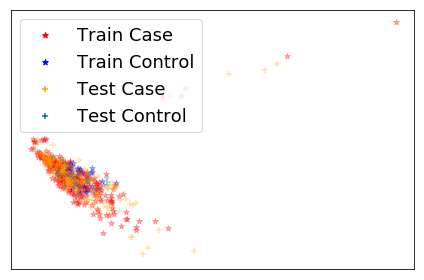

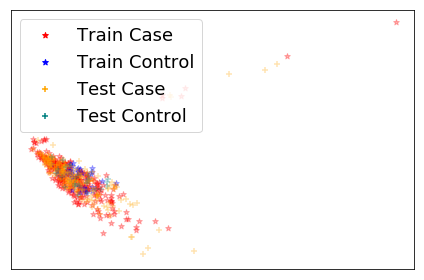

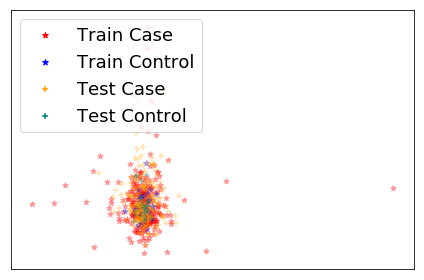

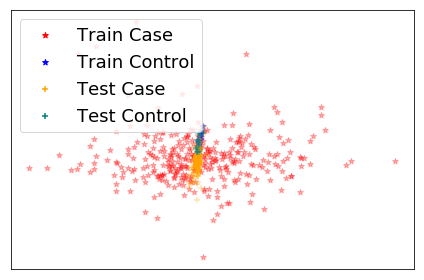

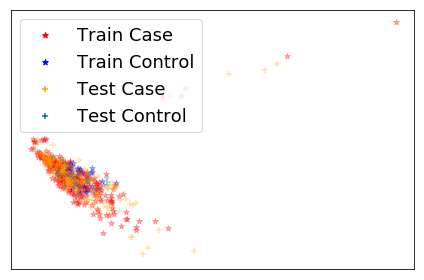

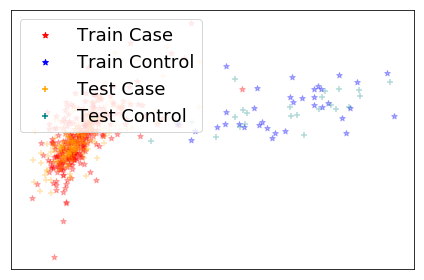

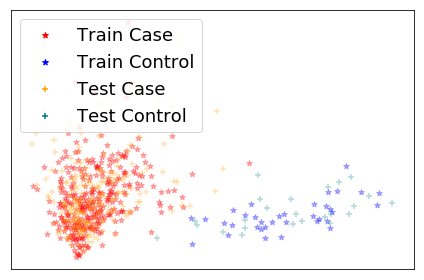

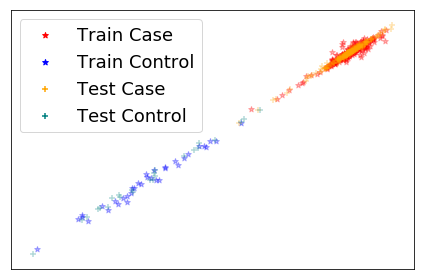

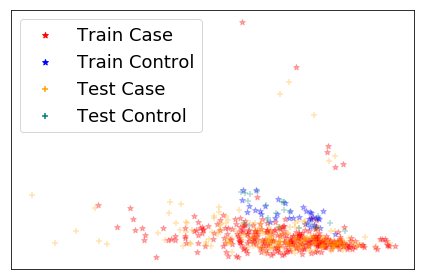

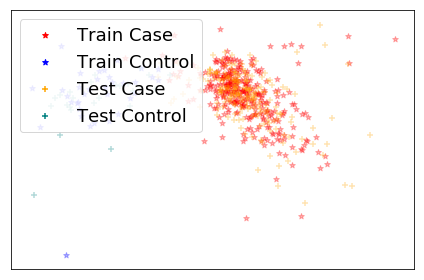

In [11]:
def plot_clusts(fg_train, bg_train, fg_test, bg_test, name):
    fig = plt.figure()
    plt.scatter(fg_train[:, 0], fg_train[:, 1], marker='*', color='red', label='Train Case', alpha=0.3)
    plt.scatter(bg_train[:, 0], bg_train[:, 1], marker='*', color='blue', label='Train Control', alpha=0.3)
    plt.scatter(fg_test[:, 0], fg_test[:, 1], marker='+', color='orange', label='Test Case', alpha=0.3)
    plt.scatter(bg_test[:, 0], bg_test[:, 1], marker='+', color='teal', label='Test Control', alpha=0.3)
    points = np.vstack((fg_test, bg_test))
    #plt.annotate("Test Sil: {:.3f}".format(silhouette_score(points, test_labels)),
    #    (np.min(points[:, 0]), np.max(points[:, 1])))
    plt.xticks([])
    plt.yticks([])
    lgd = plt.legend(fontsize=18, loc='upper left')
    for lh in lgd.legendHandles:
        lh.set_alpha(1.0)
    plt.tight_layout()
    plt.savefig("{}/Results/Clusters/{}_{}.png".format(cancer_type, fname_base, name))

if plot_clusters:
    helper = lambda train, test, name: plot_clusts(train[:n_train_fg, :2], train[n_train_fg:, :2],
                                            test[:n_fg-n_train_fg, :2], test[n_fg-n_train_fg:, :2], name)
    for (train, test, components, name) in reduced:
        helper(train, test, name)

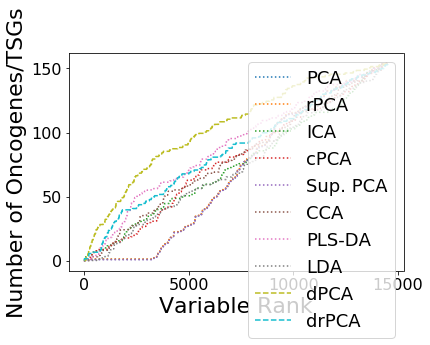

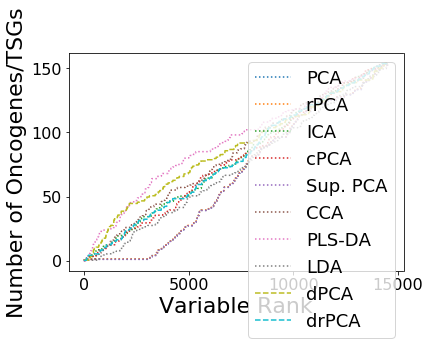

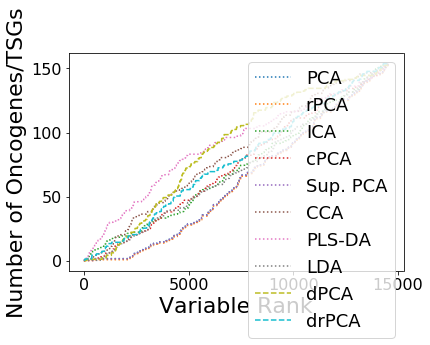

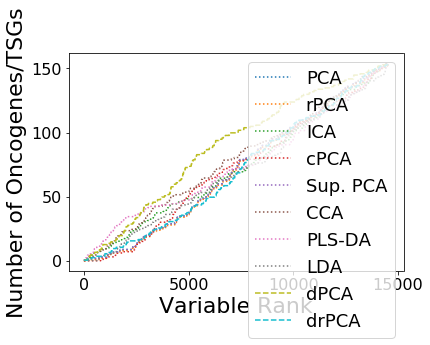

In [12]:
# Plot the Rank Curve
cosmic_genes = set([])
with open("cosmic_gene_census.tsv", 'r') as gene_census:
    for line in gene_census:
        cosmic_genes.add(line.split('\t')[0].upper())

def generate_curve(sorted_list):
    counts = []
    count = 0
    for (i, val) in sorted_list:
        if transcript_names[i].gene_name.upper() in cosmic_genes:
            count += 1
        counts.append(count)
    return counts

def plot_list_top(n):
    sort_helper = lambda components: [i for i in sorted(enumerate(np.sum(components[:n], axis=0)), key=lambda x: np.abs(x[1]), reverse=True)]
    sorted_components = [sort_helper(components) for (train, test, components, name) in reduced]

    def write_to_file(sorted_components, name):
        os.makedirs("{}/Results/Components/{}".format(cancer_type, name), exist_ok=True)
        with open("{}/Results/Components/{}/{}_{}_top_{}.csv".format(cancer_type, name, fname_base, name, n), 'w') as csv_file:
            with open("{}/Results/Components/{}/{}_{}_top_{}.tsv".format(cancer_type, name, fname_base, name, n), 'w') as tsv_file:
                for (idx, magnitude) in sorted_components:
                    print("{},{}".format(transcript_names[idx].gene_name, magnitude), file=csv_file)
                    print("{}\t{}".format(transcript_names[idx].gene_name, magnitude), file=tsv_file)

    if write_enrichment:
        for i, comps in enumerate(sorted_components):
            write_to_file(comps, reduced[i][-1])

    if plot_selection:
        fig = plt.figure()
        helper = lambda counts, name, linestyle: plt.plot(counts, label=name, linestyle=linestyle)
        for i, comps in enumerate(sorted_components):
            name = reduced[i][-1]
            if name == "drPCA" or name == "dsPCA" or name == "dPCA" or name == "dICA":
                helper(np.array(generate_curve(comps)) + np.random.uniform(0, 1), name, 'dashed')
            else:
                helper(np.array(generate_curve(comps)) + np.random.uniform(0, 1), name, 'dotted')
        plt.xlabel("Variable Rank", fontsize=22)
        plt.ylabel("Number of Oncogenes/TSGs", fontsize=22)
        ax = plt.gca()
        ax.tick_params(labelsize=16)
        plt.legend(fontsize=18)
        plt.savefig("{}/Results/oncogene_selection_top_{}_{}".format(cancer_type, n, fname_base))
    return sorted_components

if calc_onc_selection:
    sorted_components = plot_list_top(1)
    plot_list_top(2)
    plot_list_top(3)
    plot_list_top(5)

In [13]:
from sklearn.model_selection import RandomizedSearchCV
def calc_predictive(n_components=5):
    helper = lambda reps, labels, name: print("{}: {:.3f}".format(name,
        silhouette_score(reps[:, :n_components], labels)))
    print("="*20)
    print("Silhouette Scores, Training Data:")
    for (train, test, comps, name) in reduced:
        helper(train, train_labels, name)
    
    print('-'*20)
    print("Silhouette Scores, Testing Data:")
    for (train, test, comps, name) in reduced:
        helper(test, test_labels, name)
    print("="*20)

    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start= 2, stop = 15, num = 3)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(5, 20, num=5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    C_list = [0.01, 0.1, 0.5, 1., 2.5, 5.0, 10., 25.]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    lr_grid = {'C': C_list}
    def predict(x_train, x_test, y_train, y_test, calc_random):
        rf = RandomForestClassifier(n_estimators=3)
        clf = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
            n_iter=8, cv=2, verbose=0)

        clf.fit(x_train, y_train)
        #cross_validate(clf, x_train, y_train, return_train_score=False)

        if not test_tissue_type and not test_case_control:
            binarize = lambda x: label_binarize(x, classes=[0, 1, 2, 3, 4])
            auc_train = np.mean([roc_auc_score(binarize(y_train)[:, i], binarize(clf.predict(x_train))[:, i]) for i in range(5)])
            auc = np.mean([roc_auc_score(binarize(y_test)[:, i], binarize(clf.predict(x_test))[:, i]) for i in range(5)])
        else:
            auc_train = roc_auc_score(y_train, clf.predict(x_train), average='micro')
            auc = roc_auc_score(y_test, clf.predict(x_test))
        acc = accuracy_score(y_test, clf.predict(x_test))

        if calc_random:
            random_preds = np.ones_like(y_test)
            acc_random = 0.5 #accuracy_score(y_test, random_preds)
            auc_random = 0.5 #roc_auc_score(y_test, random_preds)
            return acc, auc, auc_train, acc_random, auc_random
        else:
            return acc, auc, auc_train

    if test_tissue_type:
        helper  = lambda train, test: predict(train[:n_train_fg, :n_components], test[:n_test_fg, :n_components], train_cancer_types, test_cancer_types, True)
    elif test_case_control:
        helper  = lambda train, test: predict(train[:, :n_components], test[:, :n_components], train_labels, test_labels, True)
    else:
        helper  = lambda train, test: predict(train[:n_train_fg, :n_components], test[:n_test_fg, :n_components], train_stages, test_stages, True)

    accs = []
    aucs = []
    aucs_train = []
    for (train_reduced, test_reduced, comps, name) in reduced:
        my_accs, my_auc, my_auc_train, accs_random, auc_random = helper(train_reduced, test_reduced)
        accs.append(my_accs)
        aucs.append(my_auc)
        aucs_train.append(my_auc_train)

    print("="*20)
    print("Case/Control AUC, Training Data")
    helper = lambda name, auc: print("{}: {:.3f}".format(name, auc))
    for i, auc_train in enumerate(aucs_train):
        helper(reduced[i][-1], auc_train)

    print("-"*20)
    print("Case/Control AUC, Testing Data")
    for i, auc in enumerate(aucs):
        helper(reduced[i][-1], auc)
    print("="*20)
    return aucs

N Components: 1
Silhouette Scores, Training Data:
PCA: -0.183
rPCA: -0.183
ICA: -0.295
cPCA: -0.265
Sup. PCA: -0.183
CCA: 0.846
PLS-DA: 0.811
LDA: 0.902
dPCA: -0.202
drPCA: 0.761
--------------------
Silhouette Scores, Testing Data:
PCA: -0.159
rPCA: -0.159
ICA: -0.227
cPCA: 0.021
Sup. PCA: -0.159
CCA: 0.821
PLS-DA: 0.777
LDA: 0.865
dPCA: -0.195
drPCA: 0.747


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.500
rPCA: 0.648
ICA: 0.500
cPCA: 0.983
Sup. PCA: 0.706
CCA: 0.983
PLS-DA: 0.997
LDA: 1.000
dPCA: 0.543
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.500
rPCA: 0.500
ICA: 0.500
cPCA: 0.544
Sup. PCA: 0.500
CCA: 0.954
PLS-DA: 0.970
LDA: 0.977
dPCA: 0.493
drPCA: 0.977
N Components: 2
Silhouette Scores, Training Data:
PCA: -0.194
rPCA: -0.194
ICA: -0.231
cPCA: -0.116
Sup. PCA: -0.194
CCA: 0.746
PLS-DA: 0.531
LDA: 0.901
dPCA: 0.129
drPCA: 0.684
--------------------
Silhouette Scores, Testing Data:
PCA: -0.173
rPCA: -0.172
ICA: -0.171
cPCA: 0.380
Sup. PCA: -0.173
CCA: 0.745
PLS-DA: 0.503
LDA: 0.864
dPCA: 0.114
drPCA: 0.679


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.640
rPCA: 0.598
ICA: 0.500
cPCA: 0.981
Sup. PCA: 0.627
CCA: 0.970
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.970
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.509
rPCA: 0.493
ICA: 0.500
cPCA: 0.701
Sup. PCA: 0.491
CCA: 0.954
PLS-DA: 0.979
LDA: 0.977
dPCA: 0.785
drPCA: 0.977
N Components: 3
Silhouette Scores, Training Data:
PCA: 0.276
rPCA: 0.276
ICA: -0.224
cPCA: -0.146
Sup. PCA: 0.276
CCA: 0.667
PLS-DA: 0.447
LDA: 0.902
dPCA: 0.282
drPCA: 0.534
--------------------
Silhouette Scores, Testing Data:
PCA: 0.250
rPCA: 0.250
ICA: -0.171
cPCA: 0.377
Sup. PCA: 0.250
CCA: 0.691
PLS-DA: 0.437
LDA: 0.864
dPCA: 0.271
drPCA: 0.535


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.967
rPCA: 0.965
ICA: 0.627
cPCA: 1.000
Sup. PCA: 0.995
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.971
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.870
rPCA: 0.926
ICA: 0.495
cPCA: 0.638
Sup. PCA: 0.930
CCA: 0.956
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.854
drPCA: 0.974
N Components: 4
Silhouette Scores, Training Data:
PCA: 0.258
rPCA: 0.258
ICA: -0.227
cPCA: -0.162
Sup. PCA: 0.258
CCA: 0.621
PLS-DA: 0.382
LDA: 0.903
dPCA: 0.269
drPCA: 0.479
--------------------
Silhouette Scores, Testing Data:
PCA: 0.252
rPCA: 0.252
ICA: -0.168
cPCA: 0.372
Sup. PCA: 0.252
CCA: 0.655
PLS-DA: 0.370
LDA: 0.864
dPCA: 0.255
drPCA: 0.481


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.957
rPCA: 0.986
ICA: 0.500
cPCA: 0.986
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 0.943
--------------------
Case/Control AUC, Testing Data
PCA: 0.933
rPCA: 0.954
ICA: 0.500
cPCA: 0.687
Sup. PCA: 0.933
CCA: 0.974
PLS-DA: 0.974
LDA: 0.995
dPCA: 0.956
drPCA: 0.896
N Components: 5
Silhouette Scores, Training Data:
PCA: 0.231
rPCA: 0.231
ICA: -0.225
cPCA: -0.167
Sup. PCA: 0.231
CCA: 0.589
PLS-DA: 0.369
LDA: 0.902
dPCA: 0.252
drPCA: 0.432
--------------------
Silhouette Scores, Testing Data:
PCA: 0.225
rPCA: 0.225
ICA: -0.157
cPCA: 0.366
Sup. PCA: 0.225
CCA: 0.632
PLS-DA: 0.358
LDA: 0.864
dPCA: 0.241
drPCA: 0.430


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.951
rPCA: 0.986
ICA: 0.871
cPCA: 0.986
Sup. PCA: 0.970
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.870
rPCA: 0.954
ICA: 0.491
cPCA: 0.715
Sup. PCA: 0.930
CCA: 0.974
PLS-DA: 0.951
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 6
Silhouette Scores, Training Data:
PCA: 0.221
rPCA: 0.221
ICA: -0.237
cPCA: -0.174
Sup. PCA: 0.221
CCA: 0.571
PLS-DA: 0.356
LDA: 0.902
dPCA: 0.244
drPCA: 0.371
--------------------
Silhouette Scores, Testing Data:
PCA: 0.217
rPCA: 0.217
ICA: -0.162
cPCA: 0.362
Sup. PCA: 0.217
CCA: 0.621
PLS-DA: 0.343
LDA: 0.864
dPCA: 0.234
drPCA: 0.355


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 0.514
cPCA: 0.986
Sup. PCA: 0.971
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.954
ICA: 0.500
cPCA: 0.794
Sup. PCA: 0.854
CCA: 0.954
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.935
drPCA: 0.954
N Components: 7
Silhouette Scores, Training Data:
PCA: 0.221
rPCA: 0.221
ICA: -0.226
cPCA: -0.180
Sup. PCA: 0.221
CCA: 0.555
PLS-DA: 0.352
LDA: 0.901
dPCA: 0.239
drPCA: 0.355
--------------------
Silhouette Scores, Testing Data:
PCA: 0.219
rPCA: 0.219
ICA: -0.152
cPCA: 0.359
Sup. PCA: 0.219
CCA: 0.613
PLS-DA: 0.335
LDA: 0.864
dPCA: 0.227
drPCA: 0.339


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 0.971
cPCA: 1.000
Sup. PCA: 0.971
CCA: 0.984
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.998
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.951
rPCA: 0.954
ICA: 0.548
cPCA: 0.736
Sup. PCA: 0.933
CCA: 0.956
PLS-DA: 0.917
LDA: 0.998
dPCA: 0.956
drPCA: 0.974
N Components: 8
Silhouette Scores, Training Data:
PCA: 0.211
rPCA: 0.211
ICA: 0.220
cPCA: -0.181
Sup. PCA: 0.211
CCA: 0.541
PLS-DA: 0.346
LDA: 0.901
dPCA: 0.228
drPCA: 0.337
--------------------
Silhouette Scores, Testing Data:
PCA: 0.213
rPCA: 0.213
ICA: 0.343
cPCA: 0.351
Sup. PCA: 0.213
CCA: 0.606
PLS-DA: 0.329
LDA: 0.864
dPCA: 0.216
drPCA: 0.324


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.986
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.981
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.947
ICA: 0.930
cPCA: 0.766
Sup. PCA: 0.935
CCA: 0.954
PLS-DA: 0.917
LDA: 0.977
dPCA: 0.935
drPCA: 0.956
N Components: 9
Silhouette Scores, Training Data:
PCA: 0.200
rPCA: 0.200
ICA: 0.201
cPCA: -0.185
Sup. PCA: 0.200
CCA: 0.530
PLS-DA: 0.334
LDA: 0.901
dPCA: 0.225
drPCA: 0.327
--------------------
Silhouette Scores, Testing Data:
PCA: 0.208
rPCA: 0.208
ICA: 0.336
cPCA: 0.349
Sup. PCA: 0.208
CCA: 0.602
PLS-DA: 0.317
LDA: 0.864
dPCA: 0.211
drPCA: 0.315


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.998
rPCA: 1.000
ICA: 1.000
cPCA: 0.986
Sup. PCA: 0.998
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.956
rPCA: 0.954
ICA: 0.970
cPCA: 0.733
Sup. PCA: 0.926
CCA: 0.954
PLS-DA: 0.970
LDA: 0.977
dPCA: 0.958
drPCA: 0.974
N Components: 10
Silhouette Scores, Training Data:
PCA: 0.188
rPCA: 0.188
ICA: 0.172
cPCA: -0.189
Sup. PCA: 0.188
CCA: 0.520
PLS-DA: 0.329
LDA: 0.900
dPCA: 0.218
drPCA: 0.321
--------------------
Silhouette Scores, Testing Data:
PCA: 0.196
rPCA: 0.196
ICA: 0.305
cPCA: 0.347
Sup. PCA: 0.196
CCA: 0.598
PLS-DA: 0.312
LDA: 0.864
dPCA: 0.206
drPCA: 0.308


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 0.997
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.971
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.930
rPCA: 0.956
ICA: 0.949
cPCA: 0.777
Sup. PCA: 0.956
CCA: 0.954
PLS-DA: 0.933
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 11
Silhouette Scores, Training Data:
PCA: 0.181
rPCA: 0.181
ICA: 0.145
cPCA: -0.191
Sup. PCA: 0.181
CCA: 0.510
PLS-DA: 0.324
LDA: 0.900
dPCA: 0.215
drPCA: 0.310
--------------------
Silhouette Scores, Testing Data:
PCA: 0.192
rPCA: 0.192
ICA: 0.283
cPCA: 0.343
Sup. PCA: 0.192
CCA: 0.594
PLS-DA: 0.306
LDA: 0.864
dPCA: 0.203
drPCA: 0.300


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.971
rPCA: 1.000
ICA: 0.984
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.891
rPCA: 0.954
ICA: 0.910
cPCA: 0.770
Sup. PCA: 0.875
CCA: 0.933
PLS-DA: 0.954
LDA: 0.977
dPCA: 0.935
drPCA: 0.977
N Components: 12
Silhouette Scores, Training Data:
PCA: 0.175
rPCA: 0.175
ICA: 0.115
cPCA: -0.193
Sup. PCA: 0.175
CCA: 0.499
PLS-DA: 0.321
LDA: 0.900
dPCA: 0.210
drPCA: 0.298
--------------------
Silhouette Scores, Testing Data:
PCA: 0.190
rPCA: 0.190
ICA: 0.258
cPCA: 0.340
Sup. PCA: 0.190
CCA: 0.588
PLS-DA: 0.303
LDA: 0.864
dPCA: 0.198
drPCA: 0.290


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.995
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.954
ICA: 0.963
cPCA: 0.711
Sup. PCA: 0.956
CCA: 0.972
PLS-DA: 0.972
LDA: 0.977
dPCA: 0.956
drPCA: 0.974
N Components: 13
Silhouette Scores, Training Data:
PCA: 0.167
rPCA: 0.167
ICA: 0.171
cPCA: -0.196
Sup. PCA: 0.167
CCA: 0.490
PLS-DA: 0.316
LDA: 0.900
dPCA: 0.207
drPCA: 0.294
--------------------
Silhouette Scores, Testing Data:
PCA: 0.187
rPCA: 0.187
ICA: 0.250
cPCA: 0.337
Sup. PCA: 0.187
CCA: 0.584
PLS-DA: 0.299
LDA: 0.864
dPCA: 0.195
drPCA: 0.286


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.984
rPCA: 0.986
ICA: 0.957
cPCA: 1.000
Sup. PCA: 0.970
CCA: 0.998
PLS-DA: 0.986
LDA: 1.000
dPCA: 1.000
drPCA: 0.852
--------------------
Case/Control AUC, Testing Data
PCA: 0.933
rPCA: 0.896
ICA: 0.882
cPCA: 0.773
Sup. PCA: 0.896
CCA: 0.935
PLS-DA: 0.789
LDA: 0.998
dPCA: 0.958
drPCA: 0.808
N Components: 14
Silhouette Scores, Training Data:
PCA: 0.163
rPCA: 0.163
ICA: 0.138
cPCA: -0.199
Sup. PCA: 0.163
CCA: 0.481
PLS-DA: 0.312
LDA: 0.900
dPCA: 0.205
drPCA: 0.290
--------------------
Silhouette Scores, Testing Data:
PCA: 0.186
rPCA: 0.186
ICA: 0.215
cPCA: 0.335
Sup. PCA: 0.186
CCA: 0.579
PLS-DA: 0.296
LDA: 0.864
dPCA: 0.194
drPCA: 0.282


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.943
rPCA: 0.957
ICA: 0.984
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.986
LDA: 0.998
dPCA: 0.986
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.771
rPCA: 0.849
ICA: 0.845
cPCA: 0.790
Sup. PCA: 0.893
CCA: 0.935
PLS-DA: 0.949
LDA: 0.995
dPCA: 0.935
drPCA: 0.974
N Components: 15
Silhouette Scores, Training Data:
PCA: 0.159
rPCA: 0.159
ICA: 0.123
cPCA: -0.201
Sup. PCA: 0.159
CCA: 0.473
PLS-DA: 0.308
LDA: 0.900
dPCA: 0.205
drPCA: 0.284
--------------------
Silhouette Scores, Testing Data:
PCA: 0.183
rPCA: 0.183
ICA: 0.205
cPCA: 0.332
Sup. PCA: 0.183
CCA: 0.575
PLS-DA: 0.293
LDA: 0.864
dPCA: 0.193
drPCA: 0.277


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.968
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.970
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.978
--------------------
Case/Control AUC, Testing Data
PCA: 0.947
rPCA: 0.914
ICA: 0.951
cPCA: 0.756
Sup. PCA: 0.886
CCA: 0.933
PLS-DA: 0.933
LDA: 0.977
dPCA: 0.956
drPCA: 0.967
N Components: 16
Silhouette Scores, Training Data:
PCA: 0.154
rPCA: 0.154
ICA: 0.108
cPCA: -0.203
Sup. PCA: 0.154
CCA: 0.465
PLS-DA: 0.305
LDA: 0.900
dPCA: 0.204
drPCA: 0.280
--------------------
Silhouette Scores, Testing Data:
PCA: 0.181
rPCA: 0.181
ICA: 0.195
cPCA: 0.330
Sup. PCA: 0.181
CCA: 0.571
PLS-DA: 0.290
LDA: 0.864
dPCA: 0.192
drPCA: 0.272


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 0.971
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.984
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.933
rPCA: 0.930
ICA: 0.970
cPCA: 0.739
Sup. PCA: 0.951
CCA: 0.954
PLS-DA: 0.933
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 17
Silhouette Scores, Training Data:
PCA: 0.150
rPCA: 0.150
ICA: 0.094
cPCA: -0.205
Sup. PCA: 0.150
CCA: 0.459
PLS-DA: 0.303
LDA: 0.900
dPCA: 0.200
drPCA: 0.279
--------------------
Silhouette Scores, Testing Data:
PCA: 0.179
rPCA: 0.179
ICA: 0.186
cPCA: 0.328
Sup. PCA: 0.179
CCA: 0.568
PLS-DA: 0.289
LDA: 0.864
dPCA: 0.189
drPCA: 0.267


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.986
ICA: 1.000
cPCA: 0.986
Sup. PCA: 0.998
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.893
ICA: 0.875
cPCA: 0.754
Sup. PCA: 0.935
CCA: 0.914
PLS-DA: 0.914
LDA: 0.977
dPCA: 0.956
drPCA: 0.974
N Components: 18
Silhouette Scores, Training Data:
PCA: 0.146
rPCA: 0.146
ICA: 0.085
cPCA: -0.206
Sup. PCA: 0.146
CCA: 0.451
PLS-DA: 0.300
LDA: 0.900
dPCA: 0.200
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.178
rPCA: 0.178
ICA: 0.182
cPCA: 0.325
Sup. PCA: 0.178
CCA: 0.564
PLS-DA: 0.286
LDA: 0.864
dPCA: 0.188
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.943
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.917
rPCA: 0.928
ICA: 0.967
cPCA: 0.639
Sup. PCA: 0.914
CCA: 0.745
PLS-DA: 0.949
LDA: 0.977
dPCA: 0.854
drPCA: 0.977
N Components: 19
Silhouette Scores, Training Data:
PCA: 0.142
rPCA: 0.142
ICA: 0.071
cPCA: -0.208
Sup. PCA: 0.142
CCA: 0.446
PLS-DA: 0.297
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.176
rPCA: 0.176
ICA: 0.173
cPCA: 0.323
Sup. PCA: 0.176


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


CCA: 0.561
PLS-DA: 0.282
LDA: 0.864
dPCA: 0.188
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 0.957
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.917
rPCA: 0.914
ICA: 0.933
cPCA: 0.794
Sup. PCA: 0.956
CCA: 0.954
PLS-DA: 0.930
LDA: 0.974
dPCA: 0.812
drPCA: 0.977
N Components: 20
Silhouette Scores, Training Data:
PCA: 0.138
rPCA: 0.138
ICA: 0.062
cPCA: -0.209
Sup. PCA: 0.138
CCA: 0.440
PLS-DA: 0.294
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.174
rPCA: 0.174
ICA: 0.170
cPCA: 0.321
Sup. PCA: 0.174
CCA: 0.559
PLS-DA: 0.280
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.979
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.986
LDA: 1.000
dPCA: 0.971
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.896
rPCA: 0.921
ICA: 0.914
cPCA: 0.616
Sup. PCA: 0.958
CCA: 0.870
PLS-DA: 0.914
LDA: 0.977
dPCA: 0.912
drPCA: 0.977
N Components: 21
Silhouette Scores, Training Data:
PCA: 0.133
rPCA: 0.133
ICA: 0.052
cPCA: -0.207
Sup. PCA: 0.133
CCA: 0.434
PLS-DA: 0.292
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.171
rPCA: 0.171
ICA: 0.166
cPCA: 0.319
Sup. PCA: 0.171
CCA: 0.556
PLS-DA: 0.278
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.756
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.938
ICA: 0.930
cPCA: 0.691
Sup. PCA: 0.956
CCA: 0.912
PLS-DA: 0.896
LDA: 0.977
dPCA: 0.893
drPCA: 0.706
N Components: 22
Silhouette Scores, Training Data:
PCA: 0.131
rPCA: 0.131
ICA: 0.043
cPCA: -0.208
Sup. PCA: 0.131
CCA: 0.428
PLS-DA: 0.290
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.171
rPCA: 0.171
ICA: 0.163
cPCA: 0.316
Sup. PCA: 0.171
CCA: 0.554
PLS-DA: 0.276
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.929
ICA: 0.913
cPCA: 1.000
Sup. PCA: 0.998
CCA: 0.941
PLS-DA: 0.986
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.956
rPCA: 0.810
ICA: 0.706
cPCA: 0.701
Sup. PCA: 0.935
CCA: 0.713
PLS-DA: 0.771
LDA: 0.977
dPCA: 0.956
drPCA: 0.956
N Components: 23
Silhouette Scores, Training Data:
PCA: 0.128
rPCA: 0.128
ICA: 0.029
cPCA: -0.209
Sup. PCA: 0.128
CCA: 0.424
PLS-DA: 0.287
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.170
rPCA: 0.170
ICA: 0.151
cPCA: 0.314
Sup. PCA: 0.170
CCA: 0.552
PLS-DA: 0.274
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.986
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.984
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.914
rPCA: 0.891
ICA: 0.930
cPCA: 0.719
Sup. PCA: 0.935
CCA: 0.917
PLS-DA: 0.875
LDA: 0.977
dPCA: 0.935
drPCA: 0.974
N Components: 24
Silhouette Scores, Training Data:
PCA: 0.125
rPCA: 0.125
ICA: 0.020
cPCA: -0.209
Sup. PCA: 0.125
CCA: 0.419
PLS-DA: 0.285
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.168
rPCA: 0.168
ICA: 0.147
cPCA: 0.311
Sup. PCA: 0.168
CCA: 0.550
PLS-DA: 0.273
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.971
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.991
--------------------
Case/Control AUC, Testing Data
PCA: 0.854
rPCA: 0.875
ICA: 0.951
cPCA: 0.707
Sup. PCA: 0.914
CCA: 0.891
PLS-DA: 0.917
LDA: 0.977
dPCA: 0.935
drPCA: 0.919
N Components: 1
Silhouette Scores, Training Data:
PCA: -0.183
rPCA: -0.183
ICA: -0.295
cPCA: -0.265
Sup. PCA: -0.183
CCA: 0.846
PLS-DA: 0.811
LDA: 0.902
dPCA: -0.202
drPCA: 0.761
--------------------
Silhouette Scores, Testing Data:
PCA: -0.159
rPCA: -0.159
ICA: -0.227
cPCA: 0.021
Sup. PCA: -0.159
CCA: 0.821
PLS-DA: 0.777
LDA: 0.865
dPCA: -0.195
drPCA: 0.747


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.598
rPCA: 0.584
ICA: 0.527
cPCA: 0.989
Sup. PCA: 0.605
CCA: 0.970
PLS-DA: 0.997
LDA: 1.000
dPCA: 0.554
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.509
rPCA: 0.514
ICA: 0.491
cPCA: 0.527
Sup. PCA: 0.502
CCA: 0.933
PLS-DA: 0.970
LDA: 0.977
dPCA: 0.493
drPCA: 0.977
N Components: 2
Silhouette Scores, Training Data:
PCA: -0.194
rPCA: -0.194
ICA: -0.231
cPCA: -0.116
Sup. PCA: -0.194
CCA: 0.746
PLS-DA: 0.531
LDA: 0.901
dPCA: 0.129
drPCA: 0.684
--------------------
Silhouette Scores, Testing Data:
PCA: -0.173
rPCA: -0.172
ICA: -0.171
cPCA: 0.380
Sup. PCA: -0.173
CCA: 0.745
PLS-DA: 0.503
LDA: 0.864
dPCA: 0.114
drPCA: 0.679


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.627
rPCA: 0.613
ICA: 0.500
cPCA: 0.995
Sup. PCA: 0.786
CCA: 0.964
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.488
rPCA: 0.514
ICA: 0.500
cPCA: 0.719
Sup. PCA: 0.509
CCA: 0.947
PLS-DA: 0.914
LDA: 0.977
dPCA: 0.782
drPCA: 0.914
N Components: 3
Silhouette Scores, Training Data:
PCA: 0.276
rPCA: 0.276
ICA: -0.224
cPCA: -0.146
Sup. PCA: 0.276
CCA: 0.667
PLS-DA: 0.447
LDA: 0.902
dPCA: 0.282
drPCA: 0.534
--------------------
Silhouette Scores, Testing Data:
PCA: 0.250
rPCA: 0.250
ICA: -0.171
cPCA: 0.377
Sup. PCA: 0.250
CCA: 0.691
PLS-DA: 0.437
LDA: 0.864
dPCA: 0.271
drPCA: 0.535


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.998
rPCA: 0.983
ICA: 0.500
cPCA: 0.986
Sup. PCA: 0.965
CCA: 0.997
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.951
rPCA: 0.912
ICA: 0.500
cPCA: 0.622
Sup. PCA: 0.912
CCA: 0.974
PLS-DA: 0.935
LDA: 0.977
dPCA: 0.979
drPCA: 0.977
N Components: 4
Silhouette Scores, Training Data:
PCA: 0.258
rPCA: 0.258
ICA: -0.227
cPCA: -0.162
Sup. PCA: 0.258
CCA: 0.621
PLS-DA: 0.382
LDA: 0.903
dPCA: 0.269
drPCA: 0.479
--------------------
Silhouette Scores, Testing Data:
PCA: 0.252
rPCA: 0.252
ICA: -0.168
cPCA: 0.372
Sup. PCA: 0.252
CCA: 0.655
PLS-DA: 0.370
LDA: 0.864
dPCA: 0.255
drPCA: 0.481


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 0.514
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.984
PLS-DA: 0.986
LDA: 1.000
dPCA: 0.998
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.956
rPCA: 0.914
ICA: 0.500
cPCA: 0.696
Sup. PCA: 0.954
CCA: 0.956
PLS-DA: 0.917
LDA: 0.977
dPCA: 0.956
drPCA: 0.974
N Components: 5
Silhouette Scores, Training Data:
PCA: 0.231
rPCA: 0.231
ICA: -0.225
cPCA: -0.167
Sup. PCA: 0.231
CCA: 0.589
PLS-DA: 0.369
LDA: 0.902
dPCA: 0.252
drPCA: 0.432
--------------------
Silhouette Scores, Testing Data:
PCA: 0.225
rPCA: 0.225
ICA: -0.157
cPCA: 0.366
Sup. PCA: 0.225
CCA: 0.632
PLS-DA: 0.358
LDA: 0.864
dPCA: 0.241
drPCA: 0.430


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 0.657
cPCA: 0.986
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.954
ICA: 0.500
cPCA: 0.766
Sup. PCA: 0.933
CCA: 0.954
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 6
Silhouette Scores, Training Data:
PCA: 0.221
rPCA: 0.221
ICA: -0.237
cPCA: -0.174
Sup. PCA: 0.221
CCA: 0.571
PLS-DA: 0.356
LDA: 0.902
dPCA: 0.244
drPCA: 0.371
--------------------
Silhouette Scores, Testing Data:
PCA: 0.217
rPCA: 0.217
ICA: -0.162
cPCA: 0.362
Sup. PCA: 0.217
CCA: 0.621
PLS-DA: 0.343
LDA: 0.864
dPCA: 0.234
drPCA: 0.355


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.871
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.986
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.933
ICA: 0.544
cPCA: 0.768
Sup. PCA: 0.912
CCA: 0.954
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.956
drPCA: 0.974
N Components: 7
Silhouette Scores, Training Data:
PCA: 0.221
rPCA: 0.221
ICA: -0.226
cPCA: -0.180
Sup. PCA: 0.221
CCA: 0.555
PLS-DA: 0.352
LDA: 0.901
dPCA: 0.239
drPCA: 0.355
--------------------
Silhouette Scores, Testing Data:
PCA: 0.219
rPCA: 0.219
ICA: -0.152
cPCA: 0.359
Sup. PCA: 0.219
CCA: 0.613
PLS-DA: 0.335
LDA: 0.864
dPCA: 0.227
drPCA: 0.339


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 0.971
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.933
rPCA: 0.938
ICA: 0.504
cPCA: 0.805
Sup. PCA: 0.938
CCA: 0.951
PLS-DA: 0.854
LDA: 0.977
dPCA: 0.935
drPCA: 0.977
N Components: 8
Silhouette Scores, Training Data:
PCA: 0.211
rPCA: 0.211
ICA: 0.220
cPCA: -0.181
Sup. PCA: 0.211
CCA: 0.541
PLS-DA: 0.346
LDA: 0.901
dPCA: 0.228
drPCA: 0.337
--------------------
Silhouette Scores, Testing Data:
PCA: 0.213
rPCA: 0.213
ICA: 0.343
cPCA: 0.351
Sup. PCA: 0.213
CCA: 0.606
PLS-DA: 0.329
LDA: 0.864
dPCA: 0.216
drPCA: 0.324


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.970
rPCA: 0.957
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.986
PLS-DA: 0.995
LDA: 1.000
dPCA: 1.000
drPCA: 0.929
--------------------
Case/Control AUC, Testing Data
PCA: 0.912
rPCA: 0.873
ICA: 0.930
cPCA: 0.677
Sup. PCA: 0.935
CCA: 0.935
PLS-DA: 0.940
LDA: 0.977
dPCA: 0.981
drPCA: 0.875
N Components: 9
Silhouette Scores, Training Data:
PCA: 0.200
rPCA: 0.200
ICA: 0.201
cPCA: -0.185
Sup. PCA: 0.200
CCA: 0.530
PLS-DA: 0.334
LDA: 0.901
dPCA: 0.225
drPCA: 0.327
--------------------
Silhouette Scores, Testing Data:
PCA: 0.208
rPCA: 0.208
ICA: 0.336
cPCA: 0.349
Sup. PCA: 0.208
CCA: 0.602
PLS-DA: 0.317
LDA: 0.864
dPCA: 0.211
drPCA: 0.315


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.998
rPCA: 0.986
ICA: 0.984
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.956
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.935
ICA: 0.949
cPCA: 0.740
Sup. PCA: 0.954
CCA: 0.938
PLS-DA: 0.930
LDA: 0.977
dPCA: 0.956
drPCA: 0.974
N Components: 10
Silhouette Scores, Training Data:
PCA: 0.188
rPCA: 0.188
ICA: 0.172
cPCA: -0.189
Sup. PCA: 0.188
CCA: 0.520
PLS-DA: 0.329
LDA: 0.900
dPCA: 0.218
drPCA: 0.321
--------------------
Silhouette Scores, Testing Data:
PCA: 0.196
rPCA: 0.196
ICA: 0.305
cPCA: 0.347
Sup. PCA: 0.196
CCA: 0.598
PLS-DA: 0.312
LDA: 0.864
dPCA: 0.206
drPCA: 0.308


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.978
ICA: 0.981
cPCA: 0.986
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 0.986
LDA: 0.998
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.896
ICA: 0.965
cPCA: 0.777
Sup. PCA: 0.956
CCA: 0.935
PLS-DA: 0.896
LDA: 0.974
dPCA: 0.938
drPCA: 0.977
N Components: 11
Silhouette Scores, Training Data:
PCA: 0.181
rPCA: 0.181
ICA: 0.145
cPCA: -0.191
Sup. PCA: 0.181
CCA: 0.510
PLS-DA: 0.324
LDA: 0.900
dPCA: 0.215
drPCA: 0.310
--------------------
Silhouette Scores, Testing Data:
PCA: 0.192
rPCA: 0.192
ICA: 0.283
cPCA: 0.343
Sup. PCA: 0.192
CCA: 0.594
PLS-DA: 0.306
LDA: 0.864
dPCA: 0.203
drPCA: 0.300


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.998
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.956
rPCA: 0.954
ICA: 0.970
cPCA: 0.801
Sup. PCA: 0.935
CCA: 0.956
PLS-DA: 0.935
LDA: 0.977
dPCA: 0.896
drPCA: 0.977
N Components: 12
Silhouette Scores, Training Data:
PCA: 0.175
rPCA: 0.175
ICA: 0.115
cPCA: -0.193
Sup. PCA: 0.175
CCA: 0.499
PLS-DA: 0.321
LDA: 0.900
dPCA: 0.210
drPCA: 0.298
--------------------
Silhouette Scores, Testing Data:
PCA: 0.190
rPCA: 0.190
ICA: 0.258
cPCA: 0.340
Sup. PCA: 0.190
CCA: 0.588
PLS-DA: 0.303
LDA: 0.864
dPCA: 0.198
drPCA: 0.290


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 0.983
cPCA: 1.000
Sup. PCA: 0.956
CCA: 0.998
PLS-DA: 0.998
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.840
rPCA: 0.956
ICA: 0.907
cPCA: 0.737
Sup. PCA: 0.861
CCA: 0.933
PLS-DA: 0.972
LDA: 0.977
dPCA: 0.951
drPCA: 0.974
N Components: 13
Silhouette Scores, Training Data:
PCA: 0.167
rPCA: 0.167
ICA: 0.171
cPCA: -0.196
Sup. PCA: 0.167
CCA: 0.490
PLS-DA: 0.316
LDA: 0.900
dPCA: 0.207
drPCA: 0.294
--------------------
Silhouette Scores, Testing Data:
PCA: 0.187
rPCA: 0.187
ICA: 0.250
cPCA: 0.337
Sup. PCA: 0.187
CCA: 0.584
PLS-DA: 0.299
LDA: 0.864
dPCA: 0.195
drPCA: 0.286


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.998
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.970
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.984
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.933
ICA: 0.889
cPCA: 0.695
Sup. PCA: 0.914
CCA: 0.914
PLS-DA: 0.912
LDA: 0.977
dPCA: 0.935
drPCA: 0.956
N Components: 14
Silhouette Scores, Training Data:
PCA: 0.163
rPCA: 0.163
ICA: 0.138
cPCA: -0.199
Sup. PCA: 0.163
CCA: 0.481
PLS-DA: 0.312
LDA: 0.900
dPCA: 0.205
drPCA: 0.290
--------------------
Silhouette Scores, Testing Data:
PCA: 0.186
rPCA: 0.186
ICA: 0.215
cPCA: 0.335
Sup. PCA: 0.186
CCA: 0.579
PLS-DA: 0.296
LDA: 0.864
dPCA: 0.194
drPCA: 0.282


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.984
cPCA: 1.000
Sup. PCA: 0.956
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.933
rPCA: 0.917
ICA: 0.944
cPCA: 0.819
Sup. PCA: 0.914
CCA: 0.977
PLS-DA: 0.917
LDA: 0.977
dPCA: 0.935
drPCA: 0.977
N Components: 15
Silhouette Scores, Training Data:
PCA: 0.159
rPCA: 0.159
ICA: 0.123
cPCA: -0.201
Sup. PCA: 0.159
CCA: 0.473
PLS-DA: 0.308
LDA: 0.900
dPCA: 0.205
drPCA: 0.284
--------------------
Silhouette Scores, Testing Data:
PCA: 0.183
rPCA: 0.183
ICA: 0.205
cPCA: 0.332
Sup. PCA: 0.183
CCA: 0.575
PLS-DA: 0.293
LDA: 0.864
dPCA: 0.193
drPCA: 0.277


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.986
ICA: 0.968
cPCA: 0.986
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.984
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.930
rPCA: 0.935
ICA: 0.923
cPCA: 0.780
Sup. PCA: 0.935
CCA: 0.933
PLS-DA: 0.917
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 16
Silhouette Scores, Training Data:
PCA: 0.154
rPCA: 0.154
ICA: 0.108
cPCA: -0.203
Sup. PCA: 0.154
CCA: 0.465
PLS-DA: 0.305
LDA: 0.900
dPCA: 0.204
drPCA: 0.280
--------------------
Silhouette Scores, Testing Data:
PCA: 0.181
rPCA: 0.181
ICA: 0.195
cPCA: 0.330
Sup. PCA: 0.181
CCA: 0.571
PLS-DA: 0.290
LDA: 0.864
dPCA: 0.192
drPCA: 0.272


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 0.984
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.928
ICA: 0.972
cPCA: 0.773
Sup. PCA: 0.956
CCA: 0.954
PLS-DA: 0.875
LDA: 0.974
dPCA: 0.956
drPCA: 0.977
N Components: 17
Silhouette Scores, Training Data:
PCA: 0.150
rPCA: 0.150
ICA: 0.094
cPCA: -0.205
Sup. PCA: 0.150
CCA: 0.459
PLS-DA: 0.303
LDA: 0.900
dPCA: 0.200
drPCA: 0.279
--------------------
Silhouette Scores, Testing Data:
PCA: 0.179
rPCA: 0.179
ICA: 0.186
cPCA: 0.328
Sup. PCA: 0.179
CCA: 0.568
PLS-DA: 0.289
LDA: 0.864
dPCA: 0.189
drPCA: 0.267


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.941
rPCA: 1.000
ICA: 0.952
cPCA: 0.986
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.875
rPCA: 0.933
ICA: 0.923
cPCA: 0.727
Sup. PCA: 0.954
CCA: 0.956
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.935
drPCA: 0.977
N Components: 18
Silhouette Scores, Training Data:
PCA: 0.146
rPCA: 0.146
ICA: 0.085
cPCA: -0.206
Sup. PCA: 0.146
CCA: 0.451
PLS-DA: 0.300
LDA: 0.900
dPCA: 0.200
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.178
rPCA: 0.178
ICA: 0.182
cPCA: 0.325
Sup. PCA: 0.178
CCA: 0.564
PLS-DA: 0.286
LDA: 0.864
dPCA: 0.188
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.998
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.998
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.956
rPCA: 0.893
ICA: 0.970
cPCA: 0.868
Sup. PCA: 0.870
CCA: 0.935
PLS-DA: 0.951
LDA: 0.974
dPCA: 0.935
drPCA: 0.977
N Components: 19
Silhouette Scores, Training Data:
PCA: 0.142
rPCA: 0.142
ICA: 0.071
cPCA: -0.208
Sup. PCA: 0.142
CCA: 0.446
PLS-DA: 0.297
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.176
rPCA: 0.176
ICA: 0.173
cPCA: 0.323
Sup. PCA: 0.176
CCA: 0.561
PLS-DA: 0.282
LDA: 0.864
dPCA: 0.188
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.923
ICA: 0.954
cPCA: 0.791
Sup. PCA: 0.917
CCA: 0.893
PLS-DA: 0.951
LDA: 0.977
dPCA: 0.893
drPCA: 0.977
N Components: 20
Silhouette Scores, Training Data:
PCA: 0.138
rPCA: 0.138
ICA: 0.062
cPCA: -0.209
Sup. PCA: 0.138
CCA: 0.440
PLS-DA: 0.294
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.174
rPCA: 0.174
ICA: 0.170
cPCA: 0.321
Sup. PCA: 0.174
CCA: 0.559
PLS-DA: 0.280
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.957
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 0.986
LDA: 1.000
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.852
rPCA: 0.792
ICA: 0.951
cPCA: 0.780
Sup. PCA: 0.954
CCA: 0.935
PLS-DA: 0.875
LDA: 0.977
dPCA: 0.935
drPCA: 0.926
N Components: 21
Silhouette Scores, Training Data:
PCA: 0.133
rPCA: 0.133
ICA: 0.052
cPCA: -0.207
Sup. PCA: 0.133
CCA: 0.434
PLS-DA: 0.292
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.171
rPCA: 0.171
ICA: 0.166
cPCA: 0.319
Sup. PCA: 0.171
CCA: 0.556
PLS-DA: 0.278
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.971
CCA: 0.970
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.914
rPCA: 0.935
ICA: 0.902
cPCA: 0.707
Sup. PCA: 0.912
CCA: 0.849
PLS-DA: 0.873
LDA: 0.995
dPCA: 0.933
drPCA: 0.974
N Components: 22
Silhouette Scores, Training Data:
PCA: 0.131
rPCA: 0.131
ICA: 0.043
cPCA: -0.208
Sup. PCA: 0.131
CCA: 0.428
PLS-DA: 0.290
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.171
rPCA: 0.171
ICA: 0.163
cPCA: 0.316
Sup. PCA: 0.171
CCA: 0.554
PLS-DA: 0.276
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.984
cPCA: 1.000
Sup. PCA: 0.984
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.833
rPCA: 0.935
ICA: 0.926
cPCA: 0.647
Sup. PCA: 0.870
CCA: 0.954
PLS-DA: 0.875
LDA: 0.977
dPCA: 0.935
drPCA: 0.974
N Components: 23
Silhouette Scores, Training Data:
PCA: 0.128
rPCA: 0.128
ICA: 0.029
cPCA: -0.209
Sup. PCA: 0.128
CCA: 0.424
PLS-DA: 0.287
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.170
rPCA: 0.170
ICA: 0.151
cPCA: 0.314
Sup. PCA: 0.170
CCA: 0.552
PLS-DA: 0.274
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.971
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.831
rPCA: 0.893
ICA: 0.951
cPCA: 0.626
Sup. PCA: 0.933
CCA: 0.956
PLS-DA: 0.970
LDA: 0.977
dPCA: 0.933
drPCA: 0.954
N Components: 24
Silhouette Scores, Training Data:
PCA: 0.125
rPCA: 0.125
ICA: 0.020
cPCA: -0.209
Sup. PCA: 0.125
CCA: 0.419
PLS-DA: 0.285
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.168
rPCA: 0.168
ICA: 0.147
cPCA: 0.311
Sup. PCA: 0.168
CCA: 0.550
PLS-DA: 0.273
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.957
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.893
rPCA: 0.935
ICA: 0.949
cPCA: 0.833
Sup. PCA: 0.956
CCA: 0.933
PLS-DA: 0.891
LDA: 0.977
dPCA: 0.870
drPCA: 0.974
N Components: 1
Silhouette Scores, Training Data:
PCA: -0.183
rPCA: -0.183
ICA: -0.295
cPCA: -0.265
Sup. PCA: -0.183
CCA: 0.846
PLS-DA: 0.811
LDA: 0.902
dPCA: -0.202
drPCA: 0.761
--------------------
Silhouette Scores, Testing Data:
PCA: -0.159
rPCA: -0.159
ICA: -0.227
cPCA: 0.021
Sup. PCA: -0.159
CCA: 0.821
PLS-DA: 0.777
LDA: 0.865
dPCA: -0.195
drPCA: 0.747


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.743
rPCA: 0.683
ICA: 0.500
cPCA: 0.991
Sup. PCA: 0.610
CCA: 0.983
PLS-DA: 0.997
LDA: 1.000
dPCA: 0.543
drPCA: 0.997
--------------------
Case/Control AUC, Testing Data
PCA: 0.495
rPCA: 0.509
ICA: 0.500
cPCA: 0.511
Sup. PCA: 0.504
CCA: 0.954
PLS-DA: 0.970
LDA: 0.977
dPCA: 0.498
drPCA: 0.974
N Components: 2
Silhouette Scores, Training Data:
PCA: -0.194
rPCA: -0.194
ICA: -0.231
cPCA: -0.116
Sup. PCA: -0.194
CCA: 0.746
PLS-DA: 0.531
LDA: 0.901
dPCA: 0.129
drPCA: 0.684
--------------------
Silhouette Scores, Testing Data:
PCA: -0.173
rPCA: -0.172
ICA: -0.171
cPCA: 0.380
Sup. PCA: -0.173
CCA: 0.745
PLS-DA: 0.503
LDA: 0.864
dPCA: 0.114
drPCA: 0.679


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.857
rPCA: 0.698
ICA: 0.714
cPCA: 0.983
Sup. PCA: 0.640
CCA: 0.994
PLS-DA: 0.986
LDA: 1.000
dPCA: 0.967
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.530
rPCA: 0.504
ICA: 0.495
cPCA: 0.701
Sup. PCA: 0.514
CCA: 0.974
PLS-DA: 0.979
LDA: 0.977
dPCA: 0.803
drPCA: 0.977
N Components: 3
Silhouette Scores, Training Data:
PCA: 0.276
rPCA: 0.276
ICA: -0.224
cPCA: -0.146
Sup. PCA: 0.276
CCA: 0.667
PLS-DA: 0.447
LDA: 0.902
dPCA: 0.282
drPCA: 0.534
--------------------
Silhouette Scores, Testing Data:
PCA: 0.250
rPCA: 0.250
ICA: -0.171
cPCA: 0.377
Sup. PCA: 0.250
CCA: 0.691
PLS-DA: 0.437
LDA: 0.864
dPCA: 0.271
drPCA: 0.535


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.968
rPCA: 0.967
ICA: 0.529
cPCA: 1.000
Sup. PCA: 0.997
CCA: 0.984
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.947
ICA: 0.500
cPCA: 0.680
Sup. PCA: 0.910
CCA: 0.956
PLS-DA: 0.956
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 4
Silhouette Scores, Training Data:
PCA: 0.258
rPCA: 0.258
ICA: -0.227
cPCA: -0.162
Sup. PCA: 0.258
CCA: 0.621
PLS-DA: 0.382
LDA: 0.903
dPCA: 0.269
drPCA: 0.479
--------------------
Silhouette Scores, Testing Data:
PCA: 0.252
rPCA: 0.252
ICA: -0.168
cPCA: 0.372
Sup. PCA: 0.252
CCA: 0.655
PLS-DA: 0.370
LDA: 0.864
dPCA: 0.255
drPCA: 0.481


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.500
cPCA: 1.000
Sup. PCA: 0.971
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.933
ICA: 0.500
cPCA: 0.641
Sup. PCA: 0.914
CCA: 0.956
PLS-DA: 0.954
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 5
Silhouette Scores, Training Data:
PCA: 0.231
rPCA: 0.231
ICA: -0.225
cPCA: -0.167
Sup. PCA: 0.231
CCA: 0.589
PLS-DA: 0.369
LDA: 0.902
dPCA: 0.252
drPCA: 0.432
--------------------
Silhouette Scores, Testing Data:
PCA: 0.225
rPCA: 0.225
ICA: -0.157
cPCA: 0.366
Sup. PCA: 0.225
CCA: 0.632
PLS-DA: 0.358
LDA: 0.864
dPCA: 0.241
drPCA: 0.430


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.964
rPCA: 0.986
ICA: 0.629
cPCA: 0.986
Sup. PCA: 0.986
CCA: 0.983
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.949
rPCA: 0.933
ICA: 0.495
cPCA: 0.782
Sup. PCA: 0.954
CCA: 0.958
PLS-DA: 0.977
LDA: 0.935
dPCA: 0.956
drPCA: 0.977
N Components: 6
Silhouette Scores, Training Data:
PCA: 0.221
rPCA: 0.221
ICA: -0.237
cPCA: -0.174
Sup. PCA: 0.221
CCA: 0.571
PLS-DA: 0.356
LDA: 0.902
dPCA: 0.244
drPCA: 0.371
--------------------
Silhouette Scores, Testing Data:
PCA: 0.217
rPCA: 0.217
ICA: -0.162
cPCA: 0.362
Sup. PCA: 0.217
CCA: 0.621
PLS-DA: 0.343
LDA: 0.864
dPCA: 0.234
drPCA: 0.355


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 0.998
ICA: 0.857
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.957
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.954
ICA: 0.497
cPCA: 0.745
Sup. PCA: 0.951
CCA: 0.935
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.956
drPCA: 0.974
N Components: 7
Silhouette Scores, Training Data:
PCA: 0.221
rPCA: 0.221
ICA: -0.226
cPCA: -0.180
Sup. PCA: 0.221
CCA: 0.555
PLS-DA: 0.352
LDA: 0.901
dPCA: 0.239
drPCA: 0.355
--------------------
Silhouette Scores, Testing Data:
PCA: 0.219
rPCA: 0.219
ICA: -0.152
cPCA: 0.359
Sup. PCA: 0.219
CCA: 0.613
PLS-DA: 0.335
LDA: 0.864
dPCA: 0.227
drPCA: 0.339


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.771
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.984
PLS-DA: 0.971
LDA: 1.000
dPCA: 0.971
drPCA: 0.984
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.912
ICA: 0.500
cPCA: 0.726
Sup. PCA: 0.954
CCA: 0.935
PLS-DA: 0.893
LDA: 0.977
dPCA: 0.956
drPCA: 0.914
N Components: 8
Silhouette Scores, Training Data:
PCA: 0.211
rPCA: 0.211
ICA: 0.220
cPCA: -0.181
Sup. PCA: 0.211
CCA: 0.541
PLS-DA: 0.346
LDA: 0.901
dPCA: 0.228
drPCA: 0.337
--------------------
Silhouette Scores, Testing Data:
PCA: 0.213
rPCA: 0.213
ICA: 0.343
cPCA: 0.351
Sup. PCA: 0.213
CCA: 0.606
PLS-DA: 0.329
LDA: 0.864
dPCA: 0.216
drPCA: 0.324


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.971
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.954
ICA: 0.928
cPCA: 0.789
Sup. PCA: 0.956
CCA: 0.933
PLS-DA: 0.954
LDA: 0.977
dPCA: 0.893
drPCA: 0.956
N Components: 9
Silhouette Scores, Training Data:
PCA: 0.200
rPCA: 0.200
ICA: 0.201
cPCA: -0.185
Sup. PCA: 0.200
CCA: 0.530
PLS-DA: 0.334
LDA: 0.901
dPCA: 0.225
drPCA: 0.327
--------------------
Silhouette Scores, Testing Data:
PCA: 0.208
rPCA: 0.208
ICA: 0.336
cPCA: 0.349
Sup. PCA: 0.208
CCA: 0.602
PLS-DA: 0.317
LDA: 0.864
dPCA: 0.211
drPCA: 0.315


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.984
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.970
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.998
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.951
rPCA: 0.930
ICA: 0.910
cPCA: 0.775
Sup. PCA: 0.935
CCA: 0.935
PLS-DA: 0.972
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 10
Silhouette Scores, Training Data:
PCA: 0.188
rPCA: 0.188
ICA: 0.172
cPCA: -0.189
Sup. PCA: 0.188
CCA: 0.520
PLS-DA: 0.329
LDA: 0.900
dPCA: 0.218
drPCA: 0.321
--------------------
Silhouette Scores, Testing Data:
PCA: 0.196
rPCA: 0.196
ICA: 0.305
cPCA: 0.347
Sup. PCA: 0.196
CCA: 0.598
PLS-DA: 0.312
LDA: 0.864
dPCA: 0.206
drPCA: 0.308


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.970
rPCA: 0.971
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 0.986
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.974
rPCA: 0.954
ICA: 0.930
cPCA: 0.780
Sup. PCA: 0.956
CCA: 0.954
PLS-DA: 0.914
LDA: 0.995
dPCA: 0.935
drPCA: 0.977
N Components: 11
Silhouette Scores, Training Data:
PCA: 0.181
rPCA: 0.181
ICA: 0.145
cPCA: -0.191
Sup. PCA: 0.181
CCA: 0.510
PLS-DA: 0.324
LDA: 0.900
dPCA: 0.215
drPCA: 0.310
--------------------
Silhouette Scores, Testing Data:
PCA: 0.192
rPCA: 0.192
ICA: 0.283
cPCA: 0.343
Sup. PCA: 0.192
CCA: 0.594
PLS-DA: 0.306
LDA: 0.864
dPCA: 0.203
drPCA: 0.300


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.986
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.984
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.998
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.956
ICA: 0.930
cPCA: 0.599
Sup. PCA: 0.935
CCA: 0.933
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.889
drPCA: 0.977
N Components: 12
Silhouette Scores, Training Data:
PCA: 0.175
rPCA: 0.175
ICA: 0.115
cPCA: -0.193
Sup. PCA: 0.175
CCA: 0.499
PLS-DA: 0.321
LDA: 0.900
dPCA: 0.210
drPCA: 0.298
--------------------
Silhouette Scores, Testing Data:
PCA: 0.190
rPCA: 0.190
ICA: 0.258
cPCA: 0.340
Sup. PCA: 0.190
CCA: 0.588
PLS-DA: 0.303
LDA: 0.864
dPCA: 0.198
drPCA: 0.290


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.984
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 0.986
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.856
rPCA: 0.974
ICA: 0.847
cPCA: 0.767
Sup. PCA: 0.914
CCA: 0.974
PLS-DA: 0.951
LDA: 0.977
dPCA: 0.956
drPCA: 0.970
N Components: 13
Silhouette Scores, Training Data:
PCA: 0.167
rPCA: 0.167
ICA: 0.171
cPCA: -0.196
Sup. PCA: 0.167
CCA: 0.490
PLS-DA: 0.316
LDA: 0.900
dPCA: 0.207
drPCA: 0.294
--------------------
Silhouette Scores, Testing Data:
PCA: 0.187
rPCA: 0.187
ICA: 0.250
cPCA: 0.337
Sup. PCA: 0.187
CCA: 0.584
PLS-DA: 0.299
LDA: 0.864
dPCA: 0.195
drPCA: 0.286


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 0.986
cPCA: 0.986
Sup. PCA: 0.962
CCA: 0.984
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.938
rPCA: 0.942
ICA: 0.970
cPCA: 0.835
Sup. PCA: 0.861
CCA: 0.914
PLS-DA: 0.896
LDA: 0.977
dPCA: 0.956
drPCA: 0.972
N Components: 14
Silhouette Scores, Training Data:
PCA: 0.163
rPCA: 0.163
ICA: 0.138
cPCA: -0.199
Sup. PCA: 0.163
CCA: 0.481
PLS-DA: 0.312
LDA: 0.900
dPCA: 0.205
drPCA: 0.290
--------------------
Silhouette Scores, Testing Data:
PCA: 0.186
rPCA: 0.186
ICA: 0.215
cPCA: 0.335
Sup. PCA: 0.186
CCA: 0.579
PLS-DA: 0.296
LDA: 0.864
dPCA: 0.194
drPCA: 0.282


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.914
rPCA: 0.810
ICA: 0.970
cPCA: 0.680
Sup. PCA: 0.935
CCA: 0.933
PLS-DA: 0.914
LDA: 0.977
dPCA: 0.935
drPCA: 0.956
N Components: 15
Silhouette Scores, Training Data:
PCA: 0.159
rPCA: 0.159
ICA: 0.123
cPCA: -0.201
Sup. PCA: 0.159
CCA: 0.473
PLS-DA: 0.308
LDA: 0.900
dPCA: 0.205
drPCA: 0.284
--------------------
Silhouette Scores, Testing Data:
PCA: 0.183
rPCA: 0.183
ICA: 0.205
cPCA: 0.332
Sup. PCA: 0.183
CCA: 0.575
PLS-DA: 0.293
LDA: 0.864
dPCA: 0.193
drPCA: 0.277


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.986
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.852
rPCA: 0.938
ICA: 0.951
cPCA: 0.547
Sup. PCA: 0.956
CCA: 0.854
PLS-DA: 0.938
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 16
Silhouette Scores, Training Data:
PCA: 0.154
rPCA: 0.154
ICA: 0.108
cPCA: -0.203
Sup. PCA: 0.154
CCA: 0.465
PLS-DA: 0.305
LDA: 0.900
dPCA: 0.204
drPCA: 0.280
--------------------
Silhouette Scores, Testing Data:
PCA: 0.181
rPCA: 0.181
ICA: 0.195
cPCA: 0.330
Sup. PCA: 0.181
CCA: 0.571
PLS-DA: 0.290
LDA: 0.864
dPCA: 0.192
drPCA: 0.272


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.986
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.896
rPCA: 0.914
ICA: 0.970
cPCA: 0.728
Sup. PCA: 0.935
CCA: 0.954
PLS-DA: 0.935
LDA: 0.995
dPCA: 0.956
drPCA: 0.977
N Components: 17
Silhouette Scores, Training Data:
PCA: 0.150
rPCA: 0.150
ICA: 0.094
cPCA: -0.205
Sup. PCA: 0.150
CCA: 0.459
PLS-DA: 0.303
LDA: 0.900
dPCA: 0.200
drPCA: 0.279
--------------------
Silhouette Scores, Testing Data:
PCA: 0.179
rPCA: 0.179
ICA: 0.186
cPCA: 0.328
Sup. PCA: 0.179
CCA: 0.568
PLS-DA: 0.289
LDA: 0.864
dPCA: 0.189
drPCA: 0.267


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.998
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.930
rPCA: 0.891
ICA: 0.967
cPCA: 0.780
Sup. PCA: 0.935
CCA: 0.910
PLS-DA: 0.875
LDA: 0.977
dPCA: 0.914
drPCA: 0.979
N Components: 18
Silhouette Scores, Training Data:
PCA: 0.146
rPCA: 0.146
ICA: 0.085
cPCA: -0.206
Sup. PCA: 0.146
CCA: 0.451
PLS-DA: 0.300
LDA: 0.900
dPCA: 0.200
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.178
rPCA: 0.178
ICA: 0.182
cPCA: 0.325
Sup. PCA: 0.178
CCA: 0.564
PLS-DA: 0.286
LDA: 0.864
dPCA: 0.188
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.971
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.854
rPCA: 0.914
ICA: 0.933
cPCA: 0.740
Sup. PCA: 0.914
CCA: 0.954
PLS-DA: 0.914
LDA: 0.977
dPCA: 0.914
drPCA: 0.977
N Components: 19
Silhouette Scores, Training Data:
PCA: 0.142
rPCA: 0.142
ICA: 0.071
cPCA: -0.208
Sup. PCA: 0.142
CCA: 0.446
PLS-DA: 0.297
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.176
rPCA: 0.176
ICA: 0.173
cPCA: 0.323
Sup. PCA: 0.176
CCA: 0.561
PLS-DA: 0.282
LDA: 0.864
dPCA: 0.188
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.971
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.912
rPCA: 0.875
ICA: 0.891
cPCA: 0.801
Sup. PCA: 0.951
CCA: 0.954
PLS-DA: 0.970
LDA: 0.977
dPCA: 0.914
drPCA: 0.974
N Components: 20
Silhouette Scores, Training Data:
PCA: 0.138
rPCA: 0.138
ICA: 0.062
cPCA: -0.209
Sup. PCA: 0.138
CCA: 0.440
PLS-DA: 0.294
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.174
rPCA: 0.174
ICA: 0.170
cPCA: 0.321
Sup. PCA: 0.174
CCA: 0.559
PLS-DA: 0.280
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.949
--------------------
Case/Control AUC, Testing Data
PCA: 0.870
rPCA: 0.956
ICA: 0.951
cPCA: 0.668
Sup. PCA: 0.914
CCA: 0.954
PLS-DA: 0.972
LDA: 0.977
dPCA: 0.873
drPCA: 0.835
N Components: 21
Silhouette Scores, Training Data:
PCA: 0.133
rPCA: 0.133
ICA: 0.052
cPCA: -0.207
Sup. PCA: 0.133
CCA: 0.434
PLS-DA: 0.292
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.171
rPCA: 0.171
ICA: 0.166
cPCA: 0.319
Sup. PCA: 0.171
CCA: 0.556
PLS-DA: 0.278
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.986
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.924
PLS-DA: 0.984
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.917
rPCA: 0.875
ICA: 0.972
cPCA: 0.831
Sup. PCA: 0.914
CCA: 0.764
PLS-DA: 0.933
LDA: 0.977
dPCA: 0.935
drPCA: 0.977
N Components: 22
Silhouette Scores, Training Data:
PCA: 0.131
rPCA: 0.131
ICA: 0.043
cPCA: -0.208
Sup. PCA: 0.131
CCA: 0.428
PLS-DA: 0.290
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.171
rPCA: 0.171
ICA: 0.163
cPCA: 0.316
Sup. PCA: 0.171
CCA: 0.554
PLS-DA: 0.276
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.914
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.956
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 0.986
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.833
ICA: 0.886
cPCA: 0.766
Sup. PCA: 0.896
CCA: 0.956
PLS-DA: 0.930
LDA: 0.995
dPCA: 0.891
drPCA: 0.956
N Components: 23
Silhouette Scores, Training Data:
PCA: 0.128
rPCA: 0.128
ICA: 0.029
cPCA: -0.209
Sup. PCA: 0.128
CCA: 0.424
PLS-DA: 0.287
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.170
rPCA: 0.170
ICA: 0.151
cPCA: 0.314
Sup. PCA: 0.170
CCA: 0.552
PLS-DA: 0.274
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.998
rPCA: 1.000
ICA: 0.971
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.963
rPCA: 0.914
ICA: 0.810
cPCA: 0.749
Sup. PCA: 0.896
CCA: 0.956
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.935
drPCA: 0.977
N Components: 24
Silhouette Scores, Training Data:
PCA: 0.125
rPCA: 0.125
ICA: 0.020
cPCA: -0.209
Sup. PCA: 0.125
CCA: 0.419
PLS-DA: 0.285
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.168
rPCA: 0.168
ICA: 0.147
cPCA: 0.311
Sup. PCA: 0.168
CCA: 0.550
PLS-DA: 0.273
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.968
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.986
--------------------
Case/Control AUC, Testing Data
PCA: 0.974
rPCA: 0.935
ICA: 0.970
cPCA: 0.664
Sup. PCA: 0.956
CCA: 0.912
PLS-DA: 0.833
LDA: 0.977
dPCA: 0.935
drPCA: 0.951
N Components: 1
Silhouette Scores, Training Data:
PCA: -0.183
rPCA: -0.183
ICA: -0.295
cPCA: -0.265
Sup. PCA: -0.183
CCA: 0.846
PLS-DA: 0.811
LDA: 0.902
dPCA: -0.202
drPCA: 0.761
--------------------
Silhouette Scores, Testing Data:
PCA: -0.159
rPCA: -0.159
ICA: -0.227
cPCA: 0.021
Sup. PCA: -0.159
CCA: 0.821
PLS-DA: 0.777
LDA: 0.865
dPCA: -0.195
drPCA: 0.747


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.627
rPCA: 0.652
ICA: 0.525
cPCA: 0.986
Sup. PCA: 0.554
CCA: 0.968
PLS-DA: 0.970
LDA: 0.998
dPCA: 0.557
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.528
rPCA: 0.502
ICA: 0.537
cPCA: 0.541
Sup. PCA: 0.509
CCA: 0.938
PLS-DA: 0.930
LDA: 0.974
dPCA: 0.493
drPCA: 0.977
N Components: 2
Silhouette Scores, Training Data:
PCA: -0.194
rPCA: -0.194
ICA: -0.231
cPCA: -0.116
Sup. PCA: -0.194
CCA: 0.746
PLS-DA: 0.531
LDA: 0.901
dPCA: 0.129
drPCA: 0.684
--------------------
Silhouette Scores, Testing Data:
PCA: -0.173
rPCA: -0.172
ICA: -0.171
cPCA: 0.380
Sup. PCA: -0.173
CCA: 0.745
PLS-DA: 0.503
LDA: 0.864
dPCA: 0.114
drPCA: 0.679


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.611
rPCA: 0.584
ICA: 0.500
cPCA: 1.000
Sup. PCA: 0.598
CCA: 0.998
PLS-DA: 0.998
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.514
rPCA: 0.516
ICA: 0.500
cPCA: 0.754
Sup. PCA: 0.491
CCA: 0.956
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.780
drPCA: 0.977
N Components: 3
Silhouette Scores, Training Data:
PCA: 0.276
rPCA: 0.276
ICA: -0.224
cPCA: -0.146
Sup. PCA: 0.276
CCA: 0.667
PLS-DA: 0.447
LDA: 0.902
dPCA: 0.282
drPCA: 0.534
--------------------
Silhouette Scores, Testing Data:
PCA: 0.250
rPCA: 0.250
ICA: -0.171
cPCA: 0.377
Sup. PCA: 0.250
CCA: 0.691
PLS-DA: 0.437
LDA: 0.864
dPCA: 0.271
drPCA: 0.535


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.983
rPCA: 0.967
ICA: 0.500
cPCA: 0.998
Sup. PCA: 0.998
CCA: 0.984
PLS-DA: 0.941
LDA: 1.000
dPCA: 0.943
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.933
rPCA: 0.933
ICA: 0.500
cPCA: 0.705
Sup. PCA: 0.912
CCA: 0.956
PLS-DA: 0.889
LDA: 0.956
dPCA: 0.854
drPCA: 0.977
N Components: 4
Silhouette Scores, Training Data:
PCA: 0.258
rPCA: 0.258
ICA: -0.227
cPCA: -0.162
Sup. PCA: 0.258
CCA: 0.621
PLS-DA: 0.382
LDA: 0.903
dPCA: 0.269
drPCA: 0.479
--------------------
Silhouette Scores, Testing Data:
PCA: 0.252
rPCA: 0.252
ICA: -0.168
cPCA: 0.372
Sup. PCA: 0.252
CCA: 0.655
PLS-DA: 0.370
LDA: 0.864
dPCA: 0.255
drPCA: 0.481


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.971
rPCA: 1.000
ICA: 0.586
cPCA: 1.000
Sup. PCA: 0.998
CCA: 0.984
PLS-DA: 0.997
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.938
rPCA: 0.954
ICA: 0.500
cPCA: 0.837
Sup. PCA: 0.949
CCA: 0.954
PLS-DA: 0.970
LDA: 0.977
dPCA: 0.974
drPCA: 0.954
N Components: 5
Silhouette Scores, Training Data:
PCA: 0.231
rPCA: 0.231
ICA: -0.225
cPCA: -0.167
Sup. PCA: 0.231
CCA: 0.589
PLS-DA: 0.369
LDA: 0.902
dPCA: 0.252
drPCA: 0.432
--------------------
Silhouette Scores, Testing Data:
PCA: 0.225
rPCA: 0.225
ICA: -0.157
cPCA: 0.366
Sup. PCA: 0.225
CCA: 0.632
PLS-DA: 0.358
LDA: 0.864
dPCA: 0.241
drPCA: 0.430


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.997
rPCA: 1.000
ICA: 0.557
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.984
PLS-DA: 0.986
LDA: 1.000
dPCA: 0.984
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.933
ICA: 0.495
cPCA: 0.724
Sup. PCA: 0.933
CCA: 0.954
PLS-DA: 0.917
LDA: 0.977
dPCA: 0.935
drPCA: 0.977
N Components: 6
Silhouette Scores, Training Data:
PCA: 0.221
rPCA: 0.221
ICA: -0.237
cPCA: -0.174
Sup. PCA: 0.221
CCA: 0.571
PLS-DA: 0.356
LDA: 0.902
dPCA: 0.244
drPCA: 0.371
--------------------
Silhouette Scores, Testing Data:
PCA: 0.217
rPCA: 0.217
ICA: -0.162
cPCA: 0.362
Sup. PCA: 0.217
CCA: 0.621
PLS-DA: 0.343
LDA: 0.864
dPCA: 0.234
drPCA: 0.355


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.970
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.951
rPCA: 0.930
ICA: 0.493
cPCA: 0.722
Sup. PCA: 0.930
CCA: 0.956
PLS-DA: 0.972
LDA: 0.977
dPCA: 0.958
drPCA: 0.977
N Components: 7
Silhouette Scores, Training Data:
PCA: 0.221
rPCA: 0.221
ICA: -0.226
cPCA: -0.180
Sup. PCA: 0.221
CCA: 0.555
PLS-DA: 0.352
LDA: 0.901
dPCA: 0.239
drPCA: 0.355
--------------------
Silhouette Scores, Testing Data:
PCA: 0.219
rPCA: 0.219
ICA: -0.152
cPCA: 0.359
Sup. PCA: 0.219
CCA: 0.613
PLS-DA: 0.335
LDA: 0.864
dPCA: 0.227
drPCA: 0.339


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.967
ICA: 0.986
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.947
ICA: 0.569
cPCA: 0.791
Sup. PCA: 0.956
CCA: 0.956
PLS-DA: 0.972
LDA: 0.995
dPCA: 0.935
drPCA: 0.960
N Components: 8
Silhouette Scores, Training Data:
PCA: 0.211
rPCA: 0.211
ICA: 0.220
cPCA: -0.181
Sup. PCA: 0.211
CCA: 0.541
PLS-DA: 0.346
LDA: 0.901
dPCA: 0.228
drPCA: 0.337
--------------------
Silhouette Scores, Testing Data:
PCA: 0.213
rPCA: 0.213
ICA: 0.343
cPCA: 0.351
Sup. PCA: 0.213
CCA: 0.606
PLS-DA: 0.329
LDA: 0.864
dPCA: 0.216
drPCA: 0.324


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.968
PLS-DA: 1.000
LDA: 0.986
dPCA: 0.986
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.930
rPCA: 0.954
ICA: 0.970
cPCA: 0.784
Sup. PCA: 0.933
CCA: 0.805
PLS-DA: 0.974
LDA: 0.938
dPCA: 0.956
drPCA: 0.977
N Components: 9
Silhouette Scores, Training Data:
PCA: 0.200
rPCA: 0.200
ICA: 0.201
cPCA: -0.185
Sup. PCA: 0.200
CCA: 0.530
PLS-DA: 0.334
LDA: 0.901
dPCA: 0.225
drPCA: 0.327
--------------------
Silhouette Scores, Testing Data:
PCA: 0.208
rPCA: 0.208
ICA: 0.336
cPCA: 0.349
Sup. PCA: 0.208
CCA: 0.602
PLS-DA: 0.317
LDA: 0.864
dPCA: 0.211
drPCA: 0.315


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.970
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.983
PLS-DA: 0.986
LDA: 1.000
dPCA: 0.971
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.933
rPCA: 0.956
ICA: 0.928
cPCA: 0.729
Sup. PCA: 0.954
CCA: 0.972
PLS-DA: 0.912
LDA: 0.977
dPCA: 0.958
drPCA: 0.977
N Components: 10
Silhouette Scores, Training Data:
PCA: 0.188
rPCA: 0.188
ICA: 0.172
cPCA: -0.189
Sup. PCA: 0.188
CCA: 0.520
PLS-DA: 0.329
LDA: 0.900
dPCA: 0.218
drPCA: 0.321
--------------------
Silhouette Scores, Testing Data:
PCA: 0.196
rPCA: 0.196
ICA: 0.305
cPCA: 0.347
Sup. PCA: 0.196
CCA: 0.598
PLS-DA: 0.312
LDA: 0.864
dPCA: 0.206
drPCA: 0.308


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 0.986
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.986
--------------------
Case/Control AUC, Testing Data
PCA: 0.933
rPCA: 0.928
ICA: 0.951
cPCA: 0.750
Sup. PCA: 0.954
CCA: 0.972
PLS-DA: 0.977
LDA: 0.977
dPCA: 0.935
drPCA: 0.977
N Components: 11
Silhouette Scores, Training Data:
PCA: 0.181
rPCA: 0.181
ICA: 0.145
cPCA: -0.191
Sup. PCA: 0.181
CCA: 0.510
PLS-DA: 0.324
LDA: 0.900
dPCA: 0.215
drPCA: 0.310
--------------------
Silhouette Scores, Testing Data:
PCA: 0.192
rPCA: 0.192
ICA: 0.283
cPCA: 0.343
Sup. PCA: 0.192
CCA: 0.594
PLS-DA: 0.306
LDA: 0.864
dPCA: 0.203
drPCA: 0.300


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 0.997
CCA: 0.984
PLS-DA: 0.952
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.954
ICA: 0.930
cPCA: 0.731
Sup. PCA: 0.944
CCA: 0.956
PLS-DA: 0.829
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 12
Silhouette Scores, Training Data:
PCA: 0.175
rPCA: 0.175
ICA: 0.115
cPCA: -0.193
Sup. PCA: 0.175
CCA: 0.499
PLS-DA: 0.321
LDA: 0.900
dPCA: 0.210
drPCA: 0.298
--------------------
Silhouette Scores, Testing Data:
PCA: 0.190
rPCA: 0.190
ICA: 0.258
cPCA: 0.340
Sup. PCA: 0.190
CCA: 0.588
PLS-DA: 0.303
LDA: 0.864
dPCA: 0.198
drPCA: 0.290


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.986
ICA: 0.984
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.917
rPCA: 0.938
ICA: 0.910
cPCA: 0.670
Sup. PCA: 0.974
CCA: 0.951
PLS-DA: 0.914
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 13
Silhouette Scores, Training Data:
PCA: 0.167
rPCA: 0.167
ICA: 0.171
cPCA: -0.196
Sup. PCA: 0.167
CCA: 0.490
PLS-DA: 0.316
LDA: 0.900
dPCA: 0.207
drPCA: 0.294
--------------------
Silhouette Scores, Testing Data:
PCA: 0.187
rPCA: 0.187
ICA: 0.250
cPCA: 0.337
Sup. PCA: 0.187
CCA: 0.584
PLS-DA: 0.299
LDA: 0.864
dPCA: 0.195
drPCA: 0.286


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.971
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.956
rPCA: 0.956
ICA: 0.930
cPCA: 0.698
Sup. PCA: 0.935
CCA: 0.891
PLS-DA: 0.875
LDA: 0.977
dPCA: 0.942
drPCA: 0.974
N Components: 14
Silhouette Scores, Training Data:
PCA: 0.163
rPCA: 0.163
ICA: 0.138
cPCA: -0.199
Sup. PCA: 0.163
CCA: 0.481
PLS-DA: 0.312
LDA: 0.900
dPCA: 0.205
drPCA: 0.290
--------------------
Silhouette Scores, Testing Data:
PCA: 0.186
rPCA: 0.186
ICA: 0.215
cPCA: 0.335
Sup. PCA: 0.186
CCA: 0.579
PLS-DA: 0.296
LDA: 0.864
dPCA: 0.194
drPCA: 0.282


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.970
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.956
rPCA: 0.938
ICA: 0.933
cPCA: 0.766
Sup. PCA: 0.954
CCA: 0.954
PLS-DA: 0.933
LDA: 0.977
dPCA: 0.956
drPCA: 0.974
N Components: 15
Silhouette Scores, Training Data:
PCA: 0.159
rPCA: 0.159
ICA: 0.123
cPCA: -0.201
Sup. PCA: 0.159
CCA: 0.473
PLS-DA: 0.308
LDA: 0.900
dPCA: 0.205
drPCA: 0.284
--------------------
Silhouette Scores, Testing Data:
PCA: 0.183
rPCA: 0.183
ICA: 0.205
cPCA: 0.332
Sup. PCA: 0.183
CCA: 0.575
PLS-DA: 0.293
LDA: 0.864
dPCA: 0.193
drPCA: 0.277


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 0.943
CCA: 0.998
PLS-DA: 0.984
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.933
rPCA: 0.954
ICA: 0.967
cPCA: 0.752
Sup. PCA: 0.896
CCA: 0.933
PLS-DA: 0.930
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 16
Silhouette Scores, Training Data:
PCA: 0.154
rPCA: 0.154
ICA: 0.108
cPCA: -0.203
Sup. PCA: 0.154
CCA: 0.465
PLS-DA: 0.305
LDA: 0.900
dPCA: 0.204
drPCA: 0.280
--------------------
Silhouette Scores, Testing Data:
PCA: 0.181
rPCA: 0.181
ICA: 0.195
cPCA: 0.330
Sup. PCA: 0.181
CCA: 0.571
PLS-DA: 0.290
LDA: 0.864
dPCA: 0.192
drPCA: 0.272


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.986
PLS-DA: 0.987
LDA: 1.000
dPCA: 0.998
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.930
rPCA: 0.933
ICA: 0.972
cPCA: 0.791
Sup. PCA: 0.956
CCA: 0.954
PLS-DA: 0.909
LDA: 0.977
dPCA: 0.912
drPCA: 0.977
N Components: 17
Silhouette Scores, Training Data:
PCA: 0.150
rPCA: 0.150
ICA: 0.094
cPCA: -0.205
Sup. PCA: 0.150
CCA: 0.459
PLS-DA: 0.303
LDA: 0.900
dPCA: 0.200
drPCA: 0.279
--------------------
Silhouette Scores, Testing Data:
PCA: 0.179
rPCA: 0.179
ICA: 0.186
cPCA: 0.328
Sup. PCA: 0.179
CCA: 0.568
PLS-DA: 0.289
LDA: 0.864
dPCA: 0.189
drPCA: 0.267


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.998
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.956
ICA: 0.845
cPCA: 0.624
Sup. PCA: 0.956
CCA: 0.954
PLS-DA: 0.935
LDA: 0.977
dPCA: 0.852
drPCA: 0.977
N Components: 18
Silhouette Scores, Training Data:
PCA: 0.146
rPCA: 0.146
ICA: 0.085
cPCA: -0.206
Sup. PCA: 0.146
CCA: 0.451
PLS-DA: 0.300
LDA: 0.900
dPCA: 0.200
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.178
rPCA: 0.178
ICA: 0.182
cPCA: 0.325
Sup. PCA: 0.178
CCA: 0.564
PLS-DA: 0.286
LDA: 0.864
dPCA: 0.188
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.971
PLS-DA: 1.000
LDA: 0.986
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.896
ICA: 0.933
cPCA: 0.530
Sup. PCA: 0.954
CCA: 0.810
PLS-DA: 0.914
LDA: 0.938
dPCA: 0.914
drPCA: 0.956
N Components: 19
Silhouette Scores, Training Data:
PCA: 0.142
rPCA: 0.142
ICA: 0.071
cPCA: -0.208
Sup. PCA: 0.142
CCA: 0.446
PLS-DA: 0.297
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.176
rPCA: 0.176
ICA: 0.173
cPCA: 0.323
Sup. PCA: 0.176
CCA: 0.561
PLS-DA: 0.282
LDA: 0.864
dPCA: 0.188
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.986
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.984
--------------------
Case/Control AUC, Testing Data
PCA: 0.914
rPCA: 0.852
ICA: 0.949
cPCA: 0.652
Sup. PCA: 0.956
CCA: 0.854
PLS-DA: 0.914
LDA: 0.977
dPCA: 0.935
drPCA: 0.935
N Components: 20
Silhouette Scores, Training Data:
PCA: 0.138
rPCA: 0.138
ICA: 0.062
cPCA: -0.209
Sup. PCA: 0.138
CCA: 0.440
PLS-DA: 0.294
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.174
rPCA: 0.174
ICA: 0.170
cPCA: 0.321
Sup. PCA: 0.174
CCA: 0.559
PLS-DA: 0.280
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.970
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.957
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.812
ICA: 0.951
cPCA: 0.658
Sup. PCA: 0.935
CCA: 0.912
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.893
drPCA: 0.977
N Components: 21
Silhouette Scores, Training Data:
PCA: 0.133
rPCA: 0.133
ICA: 0.052
cPCA: -0.207
Sup. PCA: 0.133
CCA: 0.434
PLS-DA: 0.292
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.171
rPCA: 0.171
ICA: 0.166
cPCA: 0.319
Sup. PCA: 0.171
CCA: 0.556
PLS-DA: 0.278
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.938
rPCA: 0.914
ICA: 0.933
cPCA: 0.621
Sup. PCA: 0.956
CCA: 0.954
PLS-DA: 0.875
LDA: 0.977
dPCA: 0.808
drPCA: 0.977
N Components: 22
Silhouette Scores, Training Data:
PCA: 0.131
rPCA: 0.131
ICA: 0.043
cPCA: -0.208
Sup. PCA: 0.131
CCA: 0.428
PLS-DA: 0.290
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.171
rPCA: 0.171
ICA: 0.163
cPCA: 0.316
Sup. PCA: 0.171
CCA: 0.554
PLS-DA: 0.276
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.971
PLS-DA: 1.000
LDA: 0.998
dPCA: 0.929
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.893
rPCA: 0.935
ICA: 0.891
cPCA: 0.675
Sup. PCA: 0.875
CCA: 0.852
PLS-DA: 0.896
LDA: 0.995
dPCA: 0.831
drPCA: 0.977
N Components: 23
Silhouette Scores, Training Data:
PCA: 0.128
rPCA: 0.128
ICA: 0.029
cPCA: -0.209
Sup. PCA: 0.128
CCA: 0.424
PLS-DA: 0.287
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.170
rPCA: 0.170
ICA: 0.151
cPCA: 0.314
Sup. PCA: 0.170
CCA: 0.552
PLS-DA: 0.274
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 0.986
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.914
rPCA: 0.912
ICA: 0.912
cPCA: 0.653
Sup. PCA: 0.835
CCA: 0.912
PLS-DA: 0.875
LDA: 0.977
dPCA: 0.873
drPCA: 0.977
N Components: 24
Silhouette Scores, Training Data:
PCA: 0.125
rPCA: 0.125
ICA: 0.020
cPCA: -0.209
Sup. PCA: 0.125
CCA: 0.419
PLS-DA: 0.285
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.168
rPCA: 0.168
ICA: 0.147
cPCA: 0.311
Sup. PCA: 0.168
CCA: 0.550
PLS-DA: 0.273
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 0.998
dPCA: 0.957
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.854
ICA: 0.947
cPCA: 0.653
Sup. PCA: 0.935
CCA: 0.933
PLS-DA: 0.917
LDA: 0.974
dPCA: 0.889
drPCA: 0.977
N Components: 1
Silhouette Scores, Training Data:
PCA: -0.183
rPCA: -0.183
ICA: -0.295
cPCA: -0.265
Sup. PCA: -0.183
CCA: 0.846
PLS-DA: 0.811
LDA: 0.902
dPCA: -0.202
drPCA: 0.761
--------------------
Silhouette Scores, Testing Data:
PCA: -0.159
rPCA: -0.159
ICA: -0.227
cPCA: 0.021
Sup. PCA: -0.159
CCA: 0.821
PLS-DA: 0.777
LDA: 0.865
dPCA: -0.195
drPCA: 0.747


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.595
rPCA: 0.622
ICA: 0.543
cPCA: 0.983
Sup. PCA: 0.581
CCA: 0.983
PLS-DA: 0.956
LDA: 1.000
dPCA: 0.624
drPCA: 0.986
--------------------
Case/Control AUC, Testing Data
PCA: 0.504
rPCA: 0.504
ICA: 0.495
cPCA: 0.516
Sup. PCA: 0.488
CCA: 0.954
PLS-DA: 0.930
LDA: 0.977
dPCA: 0.472
drPCA: 0.935
N Components: 2
Silhouette Scores, Training Data:
PCA: -0.194
rPCA: -0.194
ICA: -0.231
cPCA: -0.116
Sup. PCA: -0.194
CCA: 0.746
PLS-DA: 0.531
LDA: 0.901
dPCA: 0.129
drPCA: 0.684
--------------------
Silhouette Scores, Testing Data:
PCA: -0.173
rPCA: -0.172
ICA: -0.171
cPCA: 0.380
Sup. PCA: -0.173
CCA: 0.745
PLS-DA: 0.503
LDA: 0.864
dPCA: 0.114
drPCA: 0.679


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.614
rPCA: 0.714
ICA: 0.629
cPCA: 0.971
Sup. PCA: 0.625
CCA: 0.965
PLS-DA: 0.998
LDA: 0.998
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.516
rPCA: 0.507
ICA: 0.500
cPCA: 0.708
Sup. PCA: 0.509
CCA: 0.974
PLS-DA: 0.974
LDA: 0.974
dPCA: 0.764
drPCA: 0.935
N Components: 3
Silhouette Scores, Training Data:
PCA: 0.276
rPCA: 0.276
ICA: -0.224
cPCA: -0.146
Sup. PCA: 0.276
CCA: 0.667
PLS-DA: 0.447
LDA: 0.902
dPCA: 0.282
drPCA: 0.534
--------------------
Silhouette Scores, Testing Data:
PCA: 0.250
rPCA: 0.250
ICA: -0.171
cPCA: 0.377
Sup. PCA: 0.250
CCA: 0.691
PLS-DA: 0.437
LDA: 0.864
dPCA: 0.271
drPCA: 0.535


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.968
rPCA: 0.968
ICA: 0.500
cPCA: 1.000
Sup. PCA: 0.898
CCA: 0.981
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.912
rPCA: 0.910
ICA: 0.500
cPCA: 0.633
Sup. PCA: 0.745
CCA: 0.972
PLS-DA: 0.954
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 4
Silhouette Scores, Training Data:
PCA: 0.258
rPCA: 0.258
ICA: -0.227
cPCA: -0.162
Sup. PCA: 0.258
CCA: 0.621
PLS-DA: 0.382
LDA: 0.903
dPCA: 0.269
drPCA: 0.479
--------------------
Silhouette Scores, Testing Data:
PCA: 0.252
rPCA: 0.252
ICA: -0.168
cPCA: 0.372
Sup. PCA: 0.252
CCA: 0.655
PLS-DA: 0.370
LDA: 0.864
dPCA: 0.255
drPCA: 0.481


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 0.957
ICA: 0.557
cPCA: 0.984
Sup. PCA: 0.986
CCA: 0.984
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.787
ICA: 0.500
cPCA: 0.671
Sup. PCA: 0.935
CCA: 0.956
PLS-DA: 0.938
LDA: 0.977
dPCA: 0.956
drPCA: 0.974
N Components: 5
Silhouette Scores, Training Data:
PCA: 0.231
rPCA: 0.231
ICA: -0.225
cPCA: -0.167
Sup. PCA: 0.231
CCA: 0.589
PLS-DA: 0.369
LDA: 0.902
dPCA: 0.252
drPCA: 0.432
--------------------
Silhouette Scores, Testing Data:
PCA: 0.225
rPCA: 0.225
ICA: -0.157
cPCA: 0.366
Sup. PCA: 0.225
CCA: 0.632
PLS-DA: 0.358
LDA: 0.864
dPCA: 0.241
drPCA: 0.430


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.967
rPCA: 1.000
ICA: 0.500
cPCA: 0.986
Sup. PCA: 0.986
CCA: 0.984
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.822
rPCA: 0.956
ICA: 0.500
cPCA: 0.803
Sup. PCA: 0.954
CCA: 0.956
PLS-DA: 0.935
LDA: 0.998
dPCA: 0.956
drPCA: 0.974
N Components: 6
Silhouette Scores, Training Data:
PCA: 0.221
rPCA: 0.221
ICA: -0.237
cPCA: -0.174
Sup. PCA: 0.221
CCA: 0.571
PLS-DA: 0.356
LDA: 0.902
dPCA: 0.244
drPCA: 0.371
--------------------
Silhouette Scores, Testing Data:
PCA: 0.217
rPCA: 0.217
ICA: -0.162
cPCA: 0.362
Sup. PCA: 0.217
CCA: 0.621
PLS-DA: 0.343
LDA: 0.864
dPCA: 0.234
drPCA: 0.355


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.971
rPCA: 0.957
ICA: 0.500
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.986
drPCA: 0.997
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.912
ICA: 0.500
cPCA: 0.770
Sup. PCA: 0.935
CCA: 0.954
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.956
drPCA: 0.974
N Components: 7
Silhouette Scores, Training Data:
PCA: 0.221
rPCA: 0.221
ICA: -0.226
cPCA: -0.180
Sup. PCA: 0.221
CCA: 0.555
PLS-DA: 0.352
LDA: 0.901
dPCA: 0.239
drPCA: 0.355
--------------------
Silhouette Scores, Testing Data:
PCA: 0.219
rPCA: 0.219
ICA: -0.152
cPCA: 0.359
Sup. PCA: 0.219
CCA: 0.613
PLS-DA: 0.335
LDA: 0.864
dPCA: 0.227
drPCA: 0.339


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.543
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.968
drPCA: 0.900
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.954
ICA: 0.498
cPCA: 0.750
Sup. PCA: 0.954
CCA: 0.956
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.956
drPCA: 0.831
N Components: 8
Silhouette Scores, Training Data:
PCA: 0.211
rPCA: 0.211
ICA: 0.220
cPCA: -0.181
Sup. PCA: 0.211
CCA: 0.541
PLS-DA: 0.346
LDA: 0.901
dPCA: 0.228
drPCA: 0.337
--------------------
Silhouette Scores, Testing Data:
PCA: 0.213
rPCA: 0.213
ICA: 0.343
cPCA: 0.351
Sup. PCA: 0.213
CCA: 0.606
PLS-DA: 0.329
LDA: 0.864
dPCA: 0.216
drPCA: 0.324


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.970
rPCA: 0.956
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 0.957
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.889
rPCA: 0.838
ICA: 0.930
cPCA: 0.805
Sup. PCA: 0.956
CCA: 0.977
PLS-DA: 0.914
LDA: 0.977
dPCA: 0.938
drPCA: 0.933
N Components: 9
Silhouette Scores, Training Data:
PCA: 0.200
rPCA: 0.200
ICA: 0.201
cPCA: -0.185
Sup. PCA: 0.200
CCA: 0.530
PLS-DA: 0.334
LDA: 0.901
dPCA: 0.225
drPCA: 0.327
--------------------
Silhouette Scores, Testing Data:
PCA: 0.208
rPCA: 0.208
ICA: 0.336
cPCA: 0.349
Sup. PCA: 0.208
CCA: 0.602
PLS-DA: 0.317
LDA: 0.864
dPCA: 0.211
drPCA: 0.315


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.929
rPCA: 1.000
ICA: 0.967
cPCA: 0.986
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.875
rPCA: 0.933
ICA: 0.815
cPCA: 0.685
Sup. PCA: 0.956
CCA: 0.933
PLS-DA: 0.914
LDA: 0.977
dPCA: 0.935
drPCA: 0.977
N Components: 10
Silhouette Scores, Training Data:
PCA: 0.188
rPCA: 0.188
ICA: 0.172
cPCA: -0.189
Sup. PCA: 0.188
CCA: 0.520
PLS-DA: 0.329
LDA: 0.900
dPCA: 0.218
drPCA: 0.321
--------------------
Silhouette Scores, Testing Data:
PCA: 0.196
rPCA: 0.196
ICA: 0.305
cPCA: 0.347
Sup. PCA: 0.196
CCA: 0.598
PLS-DA: 0.312
LDA: 0.864
dPCA: 0.206
drPCA: 0.308


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.954
ICA: 0.951
cPCA: 0.661
Sup. PCA: 0.914
CCA: 0.935
PLS-DA: 0.933
LDA: 0.977
dPCA: 0.956
drPCA: 0.977
N Components: 11
Silhouette Scores, Training Data:
PCA: 0.181
rPCA: 0.181
ICA: 0.145
cPCA: -0.191
Sup. PCA: 0.181
CCA: 0.510
PLS-DA: 0.324
LDA: 0.900
dPCA: 0.215
drPCA: 0.310
--------------------
Silhouette Scores, Testing Data:
PCA: 0.192
rPCA: 0.192
ICA: 0.283
cPCA: 0.343
Sup. PCA: 0.192
CCA: 0.594
PLS-DA: 0.306
LDA: 0.864
dPCA: 0.203
drPCA: 0.300


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.971
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.986
PLS-DA: 0.943
LDA: 1.000
dPCA: 0.986
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.935
rPCA: 0.956
ICA: 0.951
cPCA: 0.703
Sup. PCA: 0.954
CCA: 0.933
PLS-DA: 0.935
LDA: 0.977
dPCA: 0.956
drPCA: 0.954
N Components: 12
Silhouette Scores, Training Data:
PCA: 0.175
rPCA: 0.175
ICA: 0.115
cPCA: -0.193
Sup. PCA: 0.175
CCA: 0.499
PLS-DA: 0.321
LDA: 0.900
dPCA: 0.210
drPCA: 0.298
--------------------
Silhouette Scores, Testing Data:
PCA: 0.190
rPCA: 0.190
ICA: 0.258
cPCA: 0.340
Sup. PCA: 0.190
CCA: 0.588
PLS-DA: 0.303
LDA: 0.864
dPCA: 0.198
drPCA: 0.290


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 0.986
Sup. PCA: 1.000
CCA: 0.971
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.956
rPCA: 0.914
ICA: 0.868
cPCA: 0.826
Sup. PCA: 0.956
CCA: 0.954
PLS-DA: 0.972
LDA: 0.977
dPCA: 0.914
drPCA: 0.977
N Components: 13
Silhouette Scores, Training Data:
PCA: 0.167
rPCA: 0.167
ICA: 0.171
cPCA: -0.196
Sup. PCA: 0.167
CCA: 0.490
PLS-DA: 0.316
LDA: 0.900
dPCA: 0.207
drPCA: 0.294
--------------------
Silhouette Scores, Testing Data:
PCA: 0.187
rPCA: 0.187
ICA: 0.250
cPCA: 0.337
Sup. PCA: 0.187
CCA: 0.584
PLS-DA: 0.299
LDA: 0.864
dPCA: 0.195
drPCA: 0.286


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.971
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.930
rPCA: 0.896
ICA: 0.891
cPCA: 0.532
Sup. PCA: 0.951
CCA: 0.956
PLS-DA: 0.875
LDA: 0.977
dPCA: 0.935
drPCA: 0.977
N Components: 14
Silhouette Scores, Training Data:
PCA: 0.163
rPCA: 0.163
ICA: 0.138
cPCA: -0.199
Sup. PCA: 0.163
CCA: 0.481
PLS-DA: 0.312
LDA: 0.900
dPCA: 0.205
drPCA: 0.290
--------------------
Silhouette Scores, Testing Data:
PCA: 0.186
rPCA: 0.186
ICA: 0.215
cPCA: 0.335
Sup. PCA: 0.186
CCA: 0.579
PLS-DA: 0.296
LDA: 0.864
dPCA: 0.194
drPCA: 0.282


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.998
cPCA: 1.000
Sup. PCA: 0.986
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.896
rPCA: 0.935
ICA: 0.914
cPCA: 0.798
Sup. PCA: 0.893
CCA: 0.954
PLS-DA: 0.974
LDA: 0.977
dPCA: 0.935
drPCA: 0.917
N Components: 15
Silhouette Scores, Training Data:
PCA: 0.159
rPCA: 0.159
ICA: 0.123
cPCA: -0.201
Sup. PCA: 0.159
CCA: 0.473
PLS-DA: 0.308
LDA: 0.900
dPCA: 0.205
drPCA: 0.284
--------------------
Silhouette Scores, Testing Data:
PCA: 0.183
rPCA: 0.183
ICA: 0.205
cPCA: 0.332
Sup. PCA: 0.183
CCA: 0.575
PLS-DA: 0.293
LDA: 0.864
dPCA: 0.193
drPCA: 0.277


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.997
ICA: 1.000
cPCA: 1.000
Sup. PCA: 0.998
CCA: 0.992
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.917
rPCA: 0.849
ICA: 0.954
cPCA: 0.570
Sup. PCA: 0.954
CCA: 0.870
PLS-DA: 0.912
LDA: 0.998
dPCA: 0.935
drPCA: 0.933
N Components: 16
Silhouette Scores, Training Data:
PCA: 0.154
rPCA: 0.154
ICA: 0.108
cPCA: -0.203
Sup. PCA: 0.154
CCA: 0.465
PLS-DA: 0.305
LDA: 0.900
dPCA: 0.204
drPCA: 0.280
--------------------
Silhouette Scores, Testing Data:
PCA: 0.181
rPCA: 0.181
ICA: 0.195
cPCA: 0.330
Sup. PCA: 0.181
CCA: 0.571
PLS-DA: 0.290
LDA: 0.864
dPCA: 0.192
drPCA: 0.272


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.998
ICA: 0.984
cPCA: 1.000
Sup. PCA: 0.971
CCA: 0.986
PLS-DA: 1.000
LDA: 0.998
dPCA: 0.986
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.956
rPCA: 0.914
ICA: 0.930
cPCA: 0.814
Sup. PCA: 0.896
CCA: 0.933
PLS-DA: 0.917
LDA: 0.977
dPCA: 0.956
drPCA: 0.974
N Components: 17
Silhouette Scores, Training Data:
PCA: 0.150
rPCA: 0.150
ICA: 0.094
cPCA: -0.205
Sup. PCA: 0.150
CCA: 0.459
PLS-DA: 0.303
LDA: 0.900
dPCA: 0.200
drPCA: 0.279
--------------------
Silhouette Scores, Testing Data:
PCA: 0.179
rPCA: 0.179
ICA: 0.186
cPCA: 0.328
Sup. PCA: 0.179
CCA: 0.568
PLS-DA: 0.289
LDA: 0.864
dPCA: 0.189
drPCA: 0.267


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.983
cPCA: 1.000
Sup. PCA: 0.986
CCA: 0.998
PLS-DA: 0.971
LDA: 0.998
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.970
rPCA: 0.935
ICA: 0.949
cPCA: 0.649
Sup. PCA: 0.912
CCA: 0.954
PLS-DA: 0.854
LDA: 0.995
dPCA: 0.914
drPCA: 0.954
N Components: 18
Silhouette Scores, Training Data:
PCA: 0.146
rPCA: 0.146
ICA: 0.085
cPCA: -0.206
Sup. PCA: 0.146
CCA: 0.451
PLS-DA: 0.300
LDA: 0.900
dPCA: 0.200
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.178
rPCA: 0.178
ICA: 0.182
cPCA: 0.325
Sup. PCA: 0.178
CCA: 0.564
PLS-DA: 0.286
LDA: 0.864
dPCA: 0.188
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 0.986
ICA: 0.927
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.984
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.896
ICA: 0.708
cPCA: 0.821
Sup. PCA: 0.933
CCA: 0.912
PLS-DA: 0.938
LDA: 0.977
dPCA: 0.954
drPCA: 0.933
N Components: 19
Silhouette Scores, Training Data:
PCA: 0.142
rPCA: 0.142
ICA: 0.071
cPCA: -0.208
Sup. PCA: 0.142
CCA: 0.446
PLS-DA: 0.297
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.176
rPCA: 0.176
ICA: 0.173
cPCA: 0.323
Sup. PCA: 0.176
CCA: 0.561
PLS-DA: 0.282
LDA: 0.864
dPCA: 0.188
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 0.900
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.998
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.893
rPCA: 0.729
ICA: 0.912
cPCA: 0.590
Sup. PCA: 0.949
CCA: 0.933
PLS-DA: 0.933
LDA: 0.977
dPCA: 0.914
drPCA: 0.977
N Components: 20
Silhouette Scores, Training Data:
PCA: 0.138
rPCA: 0.138
ICA: 0.062
cPCA: -0.209
Sup. PCA: 0.138
CCA: 0.440
PLS-DA: 0.294
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.174
rPCA: 0.174
ICA: 0.170
cPCA: 0.321
Sup. PCA: 0.174
CCA: 0.559
PLS-DA: 0.280
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.891
rPCA: 0.949
ICA: 0.933
cPCA: 0.664
Sup. PCA: 0.893
CCA: 0.930
PLS-DA: 0.873
LDA: 0.977
dPCA: 0.935
drPCA: 0.893
N Components: 21
Silhouette Scores, Training Data:
PCA: 0.133
rPCA: 0.133
ICA: 0.052
cPCA: -0.207
Sup. PCA: 0.133
CCA: 0.434
PLS-DA: 0.292
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.171
rPCA: 0.171
ICA: 0.166
cPCA: 0.319
Sup. PCA: 0.171
CCA: 0.556
PLS-DA: 0.278
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.986
rPCA: 1.000
ICA: 1.000
cPCA: 1.000
Sup. PCA: 1.000
CCA: 0.914
PLS-DA: 1.000
LDA: 1.000
dPCA: 0.951
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.954
rPCA: 0.893
ICA: 0.954
cPCA: 0.754
Sup. PCA: 0.935
CCA: 0.706
PLS-DA: 0.938
LDA: 0.977
dPCA: 0.942
drPCA: 0.977
N Components: 22
Silhouette Scores, Training Data:
PCA: 0.131
rPCA: 0.131
ICA: 0.043
cPCA: -0.208
Sup. PCA: 0.131
CCA: 0.428
PLS-DA: 0.290
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.171
rPCA: 0.171
ICA: 0.163
cPCA: 0.316
Sup. PCA: 0.171
CCA: 0.554
PLS-DA: 0.276
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 0.984
rPCA: 0.986
ICA: 0.968
cPCA: 0.986
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 1.000
dPCA: 1.000
drPCA: 0.998
--------------------
Case/Control AUC, Testing Data
PCA: 0.944
rPCA: 0.926
ICA: 0.903
cPCA: 0.835
Sup. PCA: 0.954
CCA: 0.935
PLS-DA: 0.912
LDA: 0.977
dPCA: 0.914
drPCA: 0.977
N Components: 23
Silhouette Scores, Training Data:
PCA: 0.128
rPCA: 0.128
ICA: 0.029
cPCA: -0.209
Sup. PCA: 0.128
CCA: 0.424
PLS-DA: 0.287
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.170
rPCA: 0.170
ICA: 0.151
cPCA: 0.314
Sup. PCA: 0.170
CCA: 0.552
PLS-DA: 0.274
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.900
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 1.000
--------------------
Case/Control AUC, Testing Data
PCA: 0.956
rPCA: 0.852
ICA: 0.866
cPCA: 0.750
Sup. PCA: 0.914
CCA: 0.974
PLS-DA: 0.935
LDA: 0.974
dPCA: 0.917
drPCA: 0.810
N Components: 24
Silhouette Scores, Training Data:
PCA: 0.125
rPCA: 0.125
ICA: 0.020
cPCA: -0.209
Sup. PCA: 0.125
CCA: 0.419
PLS-DA: 0.285
LDA: 0.900
dPCA: 0.199
drPCA: 0.277
--------------------
Silhouette Scores, Testing Data:
PCA: 0.168
rPCA: 0.168
ICA: 0.147
cPCA: 0.311
Sup. PCA: 0.168
CCA: 0.550
PLS-DA: 0.273
LDA: 0.864
dPCA: 0.187
drPCA: 0.264


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)
/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.

Case/Control AUC, Training Data
PCA: 1.000
rPCA: 1.000
ICA: 0.986
cPCA: 1.000
Sup. PCA: 1.000
CCA: 1.000
PLS-DA: 1.000
LDA: 0.998
dPCA: 1.000
drPCA: 0.943
--------------------
Case/Control AUC, Testing Data
PCA: 0.938
rPCA: 0.833
ICA: 0.889
cPCA: 0.764
Sup. PCA: 0.938
CCA: 0.935
PLS-DA: 0.896
LDA: 0.995
dPCA: 0.910
drPCA: 0.771
Mean Case/Control AUC, Testing Data
PCA:0.890
rPCA:0.882
ICA:0.801
cPCA:0.718
Sup. PCA:0.893
CCA:0.932
PLS-DA:0.929
LDA:0.978
dPCA:0.907
drPCA:0.958


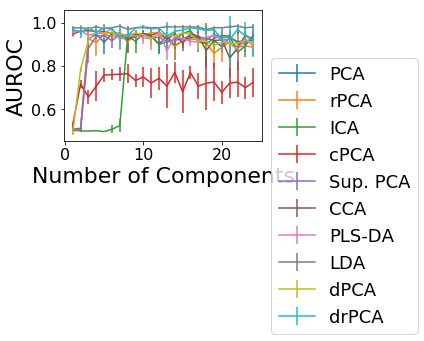

In [14]:
n_components_list = list(range(1, max_n_components))
n_iters = 5
n_methods = len(reduced)
results = np.zeros((n_methods, len(n_components_list), n_iters))
for n_iter in range(n_iters):
    for i, n_components in enumerate(n_components_list):
        print("N Components: {}".format(n_components))
        results[:, i, n_iter] = np.array(calc_predictive(n_components))

fig = plt.figure()
print("="*20)
print("Mean Case/Control AUC, Testing Data")
for i, (train, test, comps, name) in enumerate(reduced):
    if name == "Random":
        continue
    plt.errorbar(n_components_list, np.mean(results[i], axis=1), yerr=np.std(results[i], axis=1), label=name)
    print("{}:{:.3f}".format(name, np.mean(results[i])))
print("="*20)

plt.xlabel("Number of Components", fontsize=22)
plt.ylabel("AUROC", fontsize=22)
lgd = plt.legend(fontsize=18, bbox_to_anchor=(1, 0.7))
ax = plt.gca()
ax.tick_params(labelsize=16)
plt.tight_layout()
plt.savefig("{}/Results/aucroc_{}.png".format(cancer_type, fname_base), dpi=300,
    bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()